<a href="https://colab.research.google.com/github/limanhei/ElectronicStore/blob/main/bitcoin_price180-30.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Bitcoin Price Prediction: ARMA-GARCH, LSTM, Transformer, and TFT with TensorFlow and PyTorch

This notebook predicts Bitcoin prices using four models with a 30-day sliding window, incorporating technical indicators and exogenous variables (excluding whale transactions):
1. **ARMA-GARCH**: ARMA(1,1)-GARCH(1,1) with exogenous variables (TensorFlow).
2. **LSTM**: Long Short-Term Memory neural network (TensorFlow).
3. **Transformer**: Vanilla Transformer model (TensorFlow).
4. **TFT**: Temporal Fusion Transformer (PyTorch, via pytorch_forecasting).

**Data Sources**:
- Bitcoin (BTC-USD), oil (CL=F), gold (GC=F), S&P 500 (SPY) via Yahoo Finance.
- Federal Funds Rate (FEDFUNDS) and U.S. inflation rate (CPIAUCNS) via FRED API.
- Technical Indicators: SMA (20-day), EMA (20-day), RSI (14-day), MACD, Bollinger Bands, OBV.

**Metrics**:
- RMSE, MAE, MAPE for performance comparison.

## Install Dependencies
```bash
pip install yfinance pandas numpy arch statsmodels requests fredapi matplotlib tensorflow scikit-learn ta-lib torch pytorch-forecasting pytorch-lightning
```
**Note**: Install `ta-lib` for technical indicators (see [ta-lib documentation](https://mrjbq7.github.io/ta-lib/) for installation instructions). Alternatively, use `pandas_ta` (see notes).


In [ ]:
pip install yfinance pandas numpy arch statsmodels requests fredapi matplotlib tensorflow scikit-learn ta-lib

In [ ]:
pip install torch torchvision torchaudio --index-url https://download.pytorch.org/whl/cu124

Looking in indexes: https://download.pytorch.org/whl/cu124


In [ ]:
pip install pytorch-forecasting pytorch-lightning

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 260.9/260.9 kB 8.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 832.4/832.4 kB 24.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 828.5/828.5 kB 53.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 983.2/983.2 kB 58.8 MB/s eta 0:00:00


In [ ]:
horizon = 30
epochs_per_step = 50
hidden_size = 32
learning_rate = 0.002
days = 720
lookback = 360


In [ ]:
# Import libraries
import yfinance as yf
import pandas as pd
import numpy as np
from arch import arch_model
from statsmodels.tsa.arima.model import ARIMA
from fredapi import Fred
import matplotlib.pyplot as plt
from datetime import datetime, timedelta
import warnings
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras.layers import Input, MultiHeadAttention, Dense, LayerNormalization, Dropout, LSTM, Layer
from tensorflow.keras.optimizers import Adam
import torch
from pytorch_forecasting import TimeSeriesDataSet, TemporalFusionTransformer
from lightning.pytorch import Trainer
import talib
warnings.filterwarnings("ignore")

## Step 1: Data Fetching Functions
Fetch Bitcoin prices, oil prices, gold prices, S&P 500, Fed rate, and inflation rate.

In [ ]:
def fetch_bitcoin_data(start_date, end_date):
    btc = yf.download('BTC-USD', start=start_date, end=end_date, interval='1d')
    return btc['Close'].squeeze(), btc['Volume'].squeeze()  # Ensure Series

def fetch_oil_data(start_date, end_date):
    oil = yf.download('CL=F', start=start_date, end=end_date, interval='1d')
    return oil['Close'].squeeze()  # Ensure Series

def fetch_gold_data(start_date, end_date):
    gold = yf.download('GC=F', start=start_date, end=end_date, interval='1d')
    return gold['Close'].squeeze()  # Ensure Series

def fetch_sp500_data(start_date, end_date):
    sp500 = yf.download('SPY', start=start_date, end=end_date, interval='1d')
    return sp500['Close'].squeeze()  # Ensure Series

def fetch_fed_rate(start_date, end_date, api_key):
    fred = Fred(api_key=api_key)
    fed_rate = fred.get_series('FEDFUNDS', start_date=start_date, end_date=end_date)
    fed_rate.index = pd.to_datetime(fed_rate.index)
    return fed_rate

def fetch_inflation_rate(start_date, end_date, api_key):
    fred = Fred(api_key=api_key)
    cpi = fred.get_series('CPIAUCNS', start_date=start_date, end_date=end_date)
    cpi.index = pd.to_datetime(cpi.index)
    inflation_rate = cpi.pct_change(12) * 100
    return inflation_rate.dropna()

## Step 2: Data Processing
Calculate log returns for ARMA-GARCH and prepare scaled data for LSTM, Transformer, and TFT.

In [ ]:
def calculate_technical_indicators(prices, volume):
    # Ensure inputs are Series
    if not isinstance(prices, pd.Series) or not isinstance(volume, pd.Series):
        raise ValueError(f"Prices and volume must be Pandas Series, got {type(prices)}, {type(volume)}")

    # Check for NaNs
    if prices.isna().any() or volume.isna().any():
        print(f"NaNs detected: prices={prices.isna().sum()}, volume={volume.isna().sum()}")
        prices = prices.fillna(method='ffill').fillna(method='bfill')
        volume = volume.fillna(method='ffill').fillna(method='bfill')

    # Convert to float64 NumPy arrays
    prices_array = prices.astype(np.float64).values
    volume_array = volume.astype(np.float64).values

    # Calculate indicators
    sma_20 = talib.SMA(prices_array, timeperiod=20)
    ema_20 = talib.EMA(prices_array, timeperiod=20)
    rsi_14 = talib.RSI(prices_array, timeperiod=14)
    macd, macd_signal, macd_hist = talib.MACD(prices_array, fastperiod=12, slowperiod=26, signalperiod=9)
    upper_band, middle_band, lower_band = talib.BBANDS(prices_array, timeperiod=20, nbdevup=2, nbdevdn=2)
    obv = talib.OBV(prices_array, volume_array)

    # Debugging: Check for NaNs in indicators
    print(f"SMA_20 NaNs: {np.isnan(sma_20).sum()}")
    print(f"EMA_20 NaNs: {np.isnan(ema_20).sum()}")
    print(f"RSI_14 NaNs: {np.isnan(rsi_14).sum()}")
    print(f"MACD NaNs: {np.isnan(macd).sum() if macd is not None else 'None'}")
    print(f"Upper Band NaNs: {np.isnan(upper_band).sum()}")
    print(f"OBV NaNs: {np.isnan(obv).sum()}")

    # Create DataFrame with original index
    indicators = pd.DataFrame({
        'sma_20': sma_20,
        'ema_20': ema_20,
        'rsi_14': rsi_14,
        'macd': macd,
        'macd_signal': macd_signal,
        'upper_band': upper_band,
        'lower_band': lower_band,
        'obv': obv
    }, index=prices.index)

    # Fill NaNs for indicators
    indicators = indicators.fillna(method='ffill').fillna(method='bfill')

    return indicators

def calculate_log_returns(prices):
    return np.log(prices / prices.shift(1)).dropna()

def prepare_exogenous_data(btc_prices, btc_volume, oil_prices, gold_prices, sp500_prices, fed_rate, inflation_rate):
    # Ensure inputs are Series
    for name, data in [
        ('btc_prices', btc_prices), ('btc_volume', btc_volume),
        ('oil_prices', oil_prices), ('gold_prices', gold_prices),
        ('sp500_prices', sp500_prices), ('fed_rate', fed_rate),
        ('inflation_rate', inflation_rate)
    ]:
        if not isinstance(data, pd.Series):
            raise ValueError(f"{name} must be a Pandas Series, got {type(data)}")

    # Check for NaNs
    print(f"NaNs in inputs: btc_prices={btc_prices.isna().sum()}, btc_volume={btc_volume.isna().sum()}, "
          f"oil_prices={oil_prices.isna().sum()}, gold_prices={gold_prices.isna().sum()}, "
          f"sp500_prices={sp500_prices.isna().sum()}, fed_rate={fed_rate.isna().sum()}, "
          f"inflation_rate={inflation_rate.isna().sum()}")

    # Fill NaNs for inputs
    btc_prices = btc_prices.fillna(method='ffill').fillna(method='bfill')
    btc_volume = btc_volume.fillna(method='ffill').fillna(method='bfill')
    oil_prices = oil_prices.fillna(method='ffill').fillna(method='bfill')
    gold_prices = gold_prices.fillna(method='ffill').fillna(method='bfill')
    sp500_prices = sp500_prices.fillna(method='ffill').fillna(method='bfill')
    fed_rate = fed_rate.fillna(method='ffill').fillna(method='bfill')
    inflation_rate = inflation_rate.fillna(method='ffill').fillna(method='bfill')

    tech_indicators = calculate_technical_indicators(btc_prices, btc_volume)
    print(f"Technical Indicators: {len(tech_indicators)} rows")

    exog = pd.DataFrame({
        'oil_price': oil_prices,
        'gold_price': gold_prices,
        'sp500_price': sp500_prices,
        'fed_rate': fed_rate,
        'inflation_rate': inflation_rate,
        'sma_20': tech_indicators['sma_20'],
        'ema_20': tech_indicators['ema_20'],
        'rsi_14': tech_indicators['rsi_14'],
        'macd': tech_indicators['macd'],
        'macd_signal': tech_indicators['macd_signal'],
        'upper_band': tech_indicators['upper_band'],
        'lower_band': tech_indicators['lower_band'],
        'obv': tech_indicators['obv']
    }, index=btc_prices.index)

    # Check for empty exog
    if len(exog) == 0:
        raise ValueError("Exogenous DataFrame is empty after construction")

    # Drop rows with any NaNs
    exog = exog.dropna()
    print(f"Exogenous Data after dropna: {len(exog)} rows")

    return exog

def prepare_lstm_transformer_data(btc_prices, exog, lookback, horizon):
    returns = btc_prices[1:] / btc_prices[:-1]
    scaler = MinMaxScaler()
    data = pd.concat([returns.rename('returns'), exog], axis=1).dropna()
    scaled_data = scaler.fit_transform(data)

    X, y = [], []
    y_indices = []
    # Only go up to len(scaled_data) - horizon + 1
    for i in range(lookback, len(scaled_data) - horizon + 1):
        X.append(scaled_data[i-lookback:i])
        y.append(scaled_data[i+horizon-1, 0])
        y_indices.append(data.index[i+horizon-1])
    return np.array(X), np.array(y), scaler, pd.Index(y_indices)

## Step 3: ARMA-GARCH Model
Fit ARMA(1,1)-GARCH(1,1) with exogenous variables.

In [ ]:
from arch import arch_model
import pandas as pd
import numpy as np
from tqdm import tqdm

def fit_arma_garch_with_exog(returns, exog, lookback, horizon, btc_prices=None):
    predictions = []
    actuals = []
    pred_prices = []

    # Remove constant columns in exog (if any)
    constant_cols = [col for col in exog.columns if exog[col].nunique() == 1]
    if constant_cols:
        print(f"Warning: Constant columns detected in exog: {constant_cols}")
        exog = exog.drop(columns=constant_cols)
        print(f"Dropped constant columns. New exog columns: {exog.columns.tolist()}")

    idx = returns.index[lookback:]

    for n, i in enumerate(tqdm(range(lookback, len(returns)), desc="Fitting ARMA-GARCH")):
        train_returns = returns.iloc[i-lookback:i]
        try:
            model = arch_model(train_returns, vol='GARCH', p=1, q=1, mean='AR', lags=1, dist='Normal')
            res = model.fit(disp='off')
            forecast = res.forecast(horizon=horizon, reindex=False)
            pred_return = forecast.mean.values[-1, -1]
            predictions.append(pred_return)
            actuals.append(returns.iloc[i])

            # Use previous day's actual BTC price as base
            if btc_prices is not None:
                # btc_prices must be aligned with returns
                prev_price = btc_prices.iloc[i-1]
                pred_price = prev_price * np.exp(pred_return)
                pred_prices.append(pred_price)
            else:
                pred_prices.append(np.nan)
        except Exception as e:
            print(f"ARMA-GARCH fit failed at index {i}: {e}")
            predictions.append(np.nan)
            actuals.append(returns.iloc[i])
            pred_prices.append(np.nan)

    pred_returns = pd.Series(predictions, index=idx)
    actual_returns = pd.Series(actuals, index=idx)
    pred_prices = pd.Series(pred_prices, index=idx)
    return pred_prices, pred_returns, actual_returns

## Step 4: LSTM Model
Train a simple LSTM model using TensorFlow.

In [ ]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
import numpy as np
from tqdm import tqdm

print("Num GPUs Available:", len(tf.config.list_physical_devices('GPU')))
print("TensorFlow is using GPU:", tf.test.is_built_with_cuda())
print("TensorFlow version:", tf.__version__)
print("Physical devices:", tf.config.list_physical_devices())

def fit_lstm(X, y, lookback=180, epochs_per_step=50, hidden_size=32, learning_rate=0.03):
    print(f'LSTM lookback: {lookback}')
    print(f'LSTM epochs per step: {epochs_per_step}')
    predictions, actuals = [], []

    model = Sequential([
        LSTM(hidden_size, activation='relu', return_sequences=True, input_shape=(lookback, X.shape[2])),
        Dropout(0.2),
        LSTM(int(hidden_size/2), activation='relu'),
        Dense(1)
    ])
    model.compile(optimizer=Adam(learning_rate=learning_rate), loss='mse')

    for i in tqdm(range(0, len(X) - 1), desc="Fitting LSTM"):
        X_batch = X[i].reshape(1, lookback, X.shape[2])
        y_batch = np.array([y[i]])
        model.fit(X_batch, y_batch, epochs=epochs_per_step, batch_size=2048, verbose=0)
        input_sequence = X[i+1].reshape(1, lookback, X.shape[2])
        pred = model.predict(input_sequence, verbose=0)[0, 0]
        predictions.append(pred)
        actuals.append(y[i+1])

    return np.array(predictions), np.array(actuals), model

Num GPUs Available: 1
TensorFlow is using GPU: True
TensorFlow version: 2.19.0
Physical devices: [PhysicalDevice(name='/physical_device:CPU:0', device_type='CPU'), PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]


## Step 5: Transformer Model
Implement a vanilla Transformer encoder using TensorFlow’s MultiHeadAttention.

In [ ]:
from tensorflow.keras.callbacks import EarlyStopping
class TransformerEncoder(Model):
    def __init__(self, d_model=64, num_heads=4, dropout_rate=0.1):
        super(TransformerEncoder, self).__init__()
        self.input_fc = Dense(d_model)
        self.mha = MultiHeadAttention(num_heads=num_heads, key_dim=d_model // num_heads)
        self.norm1 = LayerNormalization(epsilon=1e-6)
        self.norm2 = LayerNormalization(epsilon=1e-6)
        self.dropout = Dropout(dropout_rate)
        self.ffn = Sequential([
            Dense(d_model * 4, activation='relu'),
            Dense(d_model)
        ])
        self.output_fc = Dense(1)

    def call(self, x):
        x = self.input_fc(x)
        attn_output = self.mha(x, x)
        x = self.norm1(x + self.dropout(attn_output))
        ffn_output = self.ffn(x)
        x = self.norm2(x + self.dropout(ffn_output))
        return self.output_fc(x[:, -1, :])

@tf.function(reduce_retracing=True)
def predict_transformer(model, data):
    return model(data, training=False)

def fit_transformer(X, y, lookback, epochs_per_step=50, hidden_size=32, learning_rate=0.03):
    print(f'transformer lookback: {lookback}')
    print(f'transformer epochs per step: {epochs_per_step}')
    predictions, actuals = [], []

    model = Sequential([
        tf.keras.layers.Dense(hidden_size, activation='relu', input_shape=(X.shape[1], X.shape[2])),
        Dropout(0.2),
        tf.keras.layers.Dense(int(hidden_size/2), activation='relu'),
        Dense(1)
    ])
    model.compile(optimizer=Adam(learning_rate=learning_rate), loss='mse')

    es = EarlyStopping(monitor='loss', patience=2, restore_best_weights=True)

    for i in tqdm(range(0, len(X) - 1), desc="Fitting Transformer"):
        X_batch = X[i].reshape(1, lookback, X.shape[2])
        y_batch = np.array([y[i]])
        model.fit(X_batch, y_batch, epochs=epochs_per_step, batch_size=2048, verbose=0, callbacks=[es])
        input_sequence = X[i+1].reshape(1, lookback, X.shape[2])
        pred = model.predict(input_sequence, verbose=0)[0, 0]
        predictions.append(pred)
        actuals.append(y[i+1])

    return np.array(predictions), np.array(actuals), model

## Step 6: Temporal Fusion Transformer (TFT)
Implement TFT using PyTorch Forecasting.

In [ ]:
import os, logging
from pytorch_forecasting.data.encoders import GroupNormalizer
# Silence Lightning tips/version checks and info logs
os.environ["PYTORCH_LIGHTNING_DISABLE_TELEMETRY"] = "1"
os.environ["LIGHTNING_DISABLE_VERSION_CHECK"] = "1"

for name in (
    "lightning",
    "lightning.pytorch",
    "pytorch_lightning",
    "lightning.fabric",
    "lightning.pytorch.utilities.rank_zero",
):
    logging.getLogger(name).setLevel(logging.ERROR)

def prepare_tft_data(btc_prices, exog, horizon):
    # Calculate returns
    returns = btc_prices / btc_prices.shift(1)
    avg = returns.mean()
    # Insert avg at the first position to avoid NaN at the start
    returns = pd.concat([pd.Series([avg], index=[returns.index[0]]), returns.iloc[1:]])
    returns = returns.sort_index()
    # Align indices with exog
    common_index = returns.index.intersection(exog.index)
    returns = returns.loc[common_index]
    exog = exog.loc[common_index]
    # Build DataFrame
    data = pd.concat([returns.rename('target'), exog], axis=1)
    data['Date'] = data.index  # <-- Add this line
    data = data.reset_index(drop=True)
    data['time_idx'] = range(len(data))
    data['group_id'] = '0'  # Single time series
    data = data.dropna()
    if len(data) < horizon + 1:
        raise ValueError(f"tft_data has {len(data)} rows, less than required {horizon + 1} for encoder + prediction")
    return data

def fit_tft(data, lookback, horizon, epochs_per_step=5, hidden_size=32, learning_rate=0.03):
    preds, acts, pred_prices = [], [], []
    max_encoder_length = lookback
    max_prediction_length = 1  # Only predict the 7th day ahead
    min_encoder_length = max_encoder_length // 2
    from pytorch_forecasting import TimeSeriesDataSet, TemporalFusionTransformer
    from lightning.pytorch import Trainer
    import pandas as pd
    from tqdm import tqdm
    import numpy as np

    print(f"len(data): {len(data)}, lookback: {lookback}, horizon: {horizon}")
    for i in tqdm(range(lookback, len(data) - horizon + 1), desc="Fitting TFT"):
        train_data = data.iloc[i-lookback:i].copy().reset_index(drop=True)
        test_data = data.iloc[i-lookback:i].copy().reset_index(drop=True)
        last_row = test_data.iloc[-1].copy()
        # Only generate the 7th day ahead
        row = last_row.copy()
        row['time_idx'] = last_row['time_idx'] + horizon
        row['Date'] = pd.to_datetime(last_row['Date']) + pd.Timedelta(days=horizon)
        row['target'] = last_row['target']
        decoder_data = pd.DataFrame([row])
        test_data = pd.concat([test_data, decoder_data], ignore_index=True)
        test_data = test_data.reset_index(drop=True)
        train_data = train_data[np.isfinite(train_data['target'])].dropna()
        test_data = test_data[np.isfinite(test_data['target'])].dropna()

        # --- SKIP BAD WINDOWS ---
        if len(train_data) < lookback or len(test_data) < lookback + 1:
            print(f"Skipping window {i}: not enough data after dropna (train: {len(train_data)}, test: {len(test_data)})")
            continue
        # ------------------------

        training = TimeSeriesDataSet(
            train_data,
            time_idx='time_idx',
            target='target',
            group_ids=['group_id'],
            max_encoder_length=max_encoder_length,
            min_encoder_length=min_encoder_length,
            max_prediction_length=max_prediction_length,
            target_normalizer=GroupNormalizer(groups=["group_id"], transformation="softplus"),
            static_categoricals=['group_id'],
            time_varying_known_reals=[col for col in data.columns if col not in ['Date', 'target', 'time_idx', 'group_id', 'index']],
            time_varying_unknown_reals=['target'],
            allow_missing_timesteps=True
        )

        test_dataset = TimeSeriesDataSet.from_dataset(training, test_data, predict=True)

        model = TemporalFusionTransformer.from_dataset(training, learning_rate=learning_rate, hidden_size=hidden_size, attention_head_size=int(hidden_size/8))
        trainer = Trainer(
            max_epochs=epochs_per_step,
            enable_checkpointing=False,
            enable_progress_bar=False,
            enable_model_summary=False,
        )
        trainer.fit(model, train_dataloaders=training.to_dataloader(batch_size=2048, shuffle=False))

        pred = model.predict(test_dataset, return_y=True)
        preds.append(pred.output[0].flatten()[-1].item())
        acts.append(pred.y[0].flatten()[-1].item())

    idx = pd.DatetimeIndex(pd.to_datetime([data.iloc[i]['Date'] + pd.Timedelta(days=horizon) for i in range(lookback, len(data) - horizon + 1)]))
    pred_prices = pd.Series(preds, index=idx)
    actual_prices = pd.Series(acts, index=pred_prices.index)
    return pred_prices, actual_prices

## Step 7: Main Execution
Fetch data, calculate technical indicators, fit all models, compute metrics, and visualize results.

In [ ]:
from datetime import datetime, timedelta
import yfinance as yf
import pandas as pd
import numpy as np
from sklearn.metrics import mean_squared_error, mean_absolute_error
import matplotlib.pyplot as plt
import talib
from pytorch_forecasting import TimeSeriesDataSet, TemporalFusionTransformer
from lightning.pytorch import Trainer
from tqdm import tqdm
import os

# Suppress GPU usage
# os.environ["CUDA_VISIBLE_DEVICES"] = ""

end_date = datetime.now().strftime('%Y-%m-%d')
start_date = (datetime.now() - timedelta(days=days)).strftime('%Y-%m-%d')

# API key
FRED_API_KEY = '30cb2fc5e5581d841a52d9850d6e3d3c'

# Fetch data
try:
    btc_prices, btc_volume = fetch_bitcoin_data(start_date, end_date)
    oil_prices = fetch_oil_data(start_date, end_date)
    gold_prices = fetch_gold_data(start_date, end_date)
    sp500_prices = fetch_sp500_data(start_date, end_date)
    fed_rate = fetch_fed_rate(start_date, end_date, FRED_API_KEY)
    inflation_rate = fetch_inflation_rate(start_date, end_date, FRED_API_KEY)
except Exception as e:
    print(f"Error fetching data: {e}")
    raise

# Print initial row counts and types
print(f"BTC Prices: {len(btc_prices)} rows, type: {type(btc_prices)}")
print(f"BTC Volume: {len(btc_volume)} rows, type: {type(btc_volume)}")
print(f"Oil Prices: {len(oil_prices)} rows, type: {type(oil_prices)}")
print(f"Gold Prices: {len(gold_prices)} rows, type: {type(gold_prices)}")
print(f"S&P 500 Prices: {len(sp500_prices)} rows, type: {type(sp500_prices)}")
print(f"Fed Rate: {len(fed_rate)} rows, type: {type(fed_rate)}")
print(f"Inflation Rate: {len(inflation_rate)} rows, type: {type(inflation_rate)}")

# Align data
common_index = btc_prices.index.intersection(oil_prices.index).intersection(gold_prices.index).intersection(sp500_prices.index)
print(f"Common Index: {len(common_index)} rows, from {common_index[0]} to {common_index[-1]}")

# Apply index alignment
btc_prices = btc_prices.loc[common_index]
btc_volume = btc_volume.loc[common_index]
oil_prices = oil_prices.loc[common_index]
gold_prices = gold_prices.loc[common_index]
sp500_prices = sp500_prices.loc[common_index]

# Align FRED data
fed_rate = fed_rate.reindex(common_index, method='ffill').fillna(method='ffill')
inflation_rate = inflation_rate.reindex(common_index, method='ffill').fillna(method='ffill')
print(f"Aligned Fed Rate: {len(fed_rate)} rows")
print(f"Aligned Inflation Rate: {len(inflation_rate)} rows")

# Check types and dtypes
print(f"Type of btc_prices after alignment: {type(btc_prices)}")
print(f"Type of btc_volume after alignment: {type(btc_volume)}")
print(f"Type of oil_prices after alignment: {type(oil_prices)}")
print(f"Type of gold_prices after alignment: {type(gold_prices)}")
print(f"Type of sp500_prices after alignment: {type(sp500_prices)}")
print(f"Type of fed_rate after alignment: {type(fed_rate)}")
print(f"Type of inflation_rate after alignment: {type(inflation_rate)}")
print(f"btc_prices dtype: {btc_prices.dtype}")
print(f"btc_volume dtype: {btc_volume.dtype}")
print(f"oil_prices dtype: {oil_prices.dtype}")
print(f"gold_prices dtype: {gold_prices.dtype}")
print(f"sp500_prices dtype: {sp500_prices.dtype}")

[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed


BTC Prices: 720 rows, type: <class 'pandas.core.series.Series'>
BTC Volume: 720 rows, type: <class 'pandas.core.series.Series'>
Oil Prices: 496 rows, type: <class 'pandas.core.series.Series'>
Gold Prices: 496 rows, type: <class 'pandas.core.series.Series'>
S&P 500 Prices: 494 rows, type: <class 'pandas.core.series.Series'>
Fed Rate: 854 rows, type: <class 'pandas.core.series.Series'>
Inflation Rate: 1339 rows, type: <class 'pandas.core.series.Series'>
Common Index: 494 rows, from 2023-09-18 00:00:00 to 2025-09-05 00:00:00
Aligned Fed Rate: 494 rows
Aligned Inflation Rate: 494 rows
Type of btc_prices after alignment: <class 'pandas.core.series.Series'>
Type of btc_volume after alignment: <class 'pandas.core.series.Series'>
Type of oil_prices after alignment: <class 'pandas.core.series.Series'>
Type of gold_prices after alignment: <class 'pandas.core.series.Series'>
Type of sp500_prices after alignment: <class 'pandas.core.series.Series'>
Type of fed_rate after alignment: <class 'pandas.

In [ ]:
# Prepare data for ARMA-GARCH
btc_returns = calculate_log_returns(btc_prices)
print(f"BTC Returns: {len(btc_returns)} rows")

# Prepare exogenous data
try:
    exog = prepare_exogenous_data(btc_prices, btc_volume, oil_prices, gold_prices, sp500_prices, fed_rate, inflation_rate)
    print(f"Exogenous Data: {len(exog)} rows, columns: {exog.columns.tolist()}")
    print(f"Exogenous Data dtypes:\n{exog.dtypes}")
    print("Exogenous Data unique values per column:")
    for col in exog.columns:
        print(f"{col}: {exog[col].nunique()} unique values")
except Exception as e:
    print(f"Error preparing exogenous data: {e}")
    raise

# Align returns with exogenous data
btc_returns = btc_returns[btc_returns.index.isin(exog.index)]
print(f"Aligned BTC Returns: {len(btc_returns)} rows")

# Check if btc_returns is empty
if len(btc_returns) == 0:
    raise ValueError("Aligned BTC Returns is empty. Check exogenous data preparation.")

# Fit ARMA-GARCH
try:
    print("Starting ARMA-GARCH fitting...")
    pred_prices_arma, pred_returns_arma, actual_returns = fit_arma_garch_with_exog(btc_returns, exog, lookback, horizon, btc_prices)
    print(f"ARMA-GARCH Predictions: {len(pred_returns_arma)} rows")
    # 1. Align indices to actual BTC prices
    common_idx = btc_prices.index.intersection(pred_returns_arma.index)
    pred_returns_arma = pred_returns_arma.loc[common_idx]
    actual_returns = actual_returns.loc[common_idx]

    # 2. Use the correct initial price (the price just before the prediction window)
    if len(common_idx) > 0:
        first_pred_pos = btc_prices.index.get_loc(common_idx[0])
        if first_pred_pos == 0:
            raise ValueError("Not enough data to get initial price before prediction window.")
        initial_price = btc_prices.iloc[first_pred_pos - 1]
    else:
        raise ValueError("No common index between btc_prices and pred_returns_arma.")
    # 3. Reconstruct prices from returns
    # pred_prices_arma, actual_prices = returns_to_prices(pred_returns_arma, actual_returns, initial_price)

    # 4. Align again to btc_prices for metrics/plotting
    common_idx_prices = btc_prices.index.intersection(pred_prices_arma.index)
    pred_prices_arma = pred_prices_arma.loc[common_idx_prices]
    actual_prices = btc_prices.loc[common_idx_prices]
except Exception as e:
    print(f"Error fitting ARMA-GARCH: {e}")
    raise
print(initial_price)
print(pred_prices_arma)
print(actual_prices)

BTC Returns: 493 rows
NaNs in inputs: btc_prices=0, btc_volume=0, oil_prices=0, gold_prices=0, sp500_prices=0, fed_rate=0, inflation_rate=0
SMA_20 NaNs: 19
EMA_20 NaNs: 19
RSI_14 NaNs: 14
MACD NaNs: 33
Upper Band NaNs: 19
OBV NaNs: 0
Technical Indicators: 494 rows
Exogenous Data after dropna: 494 rows
Exogenous Data: 494 rows, columns: ['oil_price', 'gold_price', 'sp500_price', 'fed_rate', 'inflation_rate', 'sma_20', 'ema_20', 'rsi_14', 'macd', 'macd_signal', 'upper_band', 'lower_band', 'obv']
Exogenous Data dtypes:
oil_price         float64
gold_price        float64
sp500_price       float64
fed_rate          float64
inflation_rate    float64
sma_20            float64
ema_20            float64
rsi_14            float64
macd              float64
macd_signal       float64
upper_band        float64
lower_band        float64
obv               float64
dtype: object
Exogenous Data unique values per column:
oil_price: 449 unique values
gold_price: 481 unique values
sp500_price: 494 unique va

Fitting ARMA-GARCH: 100%|██████████| 133/133 [00:03<00:00, 39.88it/s]

ARMA-GARCH Predictions: 133 rows
88736.171875
Date
2025-02-26     91713.902894
2025-02-27     89013.481662
2025-02-28     84620.644935
2025-03-03     84977.617321
2025-03-04     84654.376756
                  ...      
2025-08-29    111416.223673
2025-09-02    112705.811577
2025-09-03    108573.086995
2025-09-04    111370.892219
2025-09-05    111889.319700
Length: 133, dtype: float64
Date
2025-02-26     84347.023438
2025-02-27     84704.226562
2025-02-28     84373.007812
2025-03-03     86065.671875
2025-03-04     87222.195312
                  ...      
2025-08-29    108410.835938
2025-09-02    111200.585938
2025-09-03    111723.210938
2025-09-04    110723.601562
2025-09-05    110650.984375
Name: BTC-USD, Length: 133, dtype: float64


In [ ]:
# Prepare data for LSTM/Transformer (returns)
X, y, scaler, y_index = prepare_lstm_transformer_data(btc_prices, exog, lookback, horizon)

In [ ]:
# Fit LSTM
pred_scaled_lstm, actual_scaled_lstm, lstm_model = fit_lstm(X, y, lookback, epochs_per_step, hidden_size, learning_rate)

LSTM lookback: 360
LSTM epochs per step: 50


Fitting LSTM: 100%|██████████| 102/102 [06:43<00:00,  3.96s/it]


In [ ]:
# Permutation Feature Importance for LSTM/Transformer
import numpy as np
from sklearn.metrics import mean_squared_error

def permutation_importance(model, X, y, metric_fn, feature_names, n_repeats=3):
    baseline_preds = model.predict(X, verbose=0).ravel()
    baseline_score = metric_fn(y, baseline_preds)
    importances = []
    for col in range(X.shape[2]):
        scores = []
        for _ in range(n_repeats):
            X_permuted = X.copy()
            idx = np.random.permutation(X.shape[0])
            X_permuted[:, :, col] = X_permuted[idx, :, col]
            preds = model.predict(X_permuted, verbose=0).ravel()
            score = metric_fn(y, preds)
            scores.append(score)
        importances.append(np.mean(scores) - baseline_score)
    return dict(zip(feature_names, importances))

In [ ]:
# Example usage after LSTM training:
feature_names = scaler.feature_names_in_
lstm_importance = permutation_importance(
    lstm_model, X[-len(pred_scaled_lstm):], actual_scaled_lstm, mean_squared_error, feature_names
)
print("LSTM Feature Importances (higher = more important):")
for k, v in sorted(lstm_importance.items(), key=lambda x: -abs(x[1])):
    print(f"{k}: {v:.8f}")

# Build proper indices: y_index aligns to y; predictions start at y_index[lookback:]
lstm_index = btc_prices.index[-len(pred_scaled_lstm):] + pd.DateOffset(days=horizon)

# Inverse-scale with the correct baseline features
# Get the mean of each feature from the scaler's data
feature_means = scaler.data_min_ + (scaler.data_max_ - scaler.data_min_) / 2

# For LSTM
X_flat_lstm = np.tile(feature_means, (len(pred_scaled_lstm), 1))
X_flat_lstm[:, 0] = pred_scaled_lstm.ravel()
pred_return_lstm = scaler.inverse_transform(X_flat_lstm)[:, 0]

X_flat_lstm[:, 0] = actual_scaled_lstm.ravel()
actual_return_lstm = scaler.inverse_transform(X_flat_lstm)[:, 0]

pred_return_lstm = pd.Series(pred_return_lstm, index=lstm_index)
actual_return_lstm = pd.Series(actual_return_lstm, index=lstm_index)

pred_prices_lstm = pd.Series(index=pred_return_lstm.index, dtype=float)
actual_prices_lstm = pd.Series(index=actual_return_lstm.index, dtype=float)

for i, date in enumerate(pred_return_lstm.index):
    # Get previous date (one day before)
    prev_date = date - pd.Timedelta(days=1)
    # Use actual previous day's price for both
    if prev_date in btc_prices.index:
        prev_price = btc_prices.loc[prev_date]
        pred_prices_lstm.loc[date] = prev_price * pred_return_lstm.loc[date]
        actual_prices_lstm.loc[date] = prev_price * actual_return_lstm.loc[date]
    else:
        pred_prices_lstm.loc[date] = np.nan
        actual_prices_lstm.loc[date] = np.nan

# Align to the plotting/metrics range
common_idx = actual_prices.index.intersection(pred_prices_lstm.index)
pred_prices_lstm = pred_prices_lstm.loc[common_idx]
actual_prices_lstm = actual_prices_lstm.loc[common_idx]
print(f"LSTM Predictions: {len(pred_prices_lstm)} rows")

print(pred_return_lstm)

LSTM Feature Importances (higher = more important):
sp500_price: 0.00000201
macd: 0.00000131
rsi_14: -0.00000092
macd_signal: 0.00000091
inflation_rate: -0.00000078
ema_20: -0.00000046
gold_price: -0.00000045
oil_price: -0.00000032
upper_band: -0.00000014
sma_20: 0.00000008
obv: -0.00000008
lower_band: -0.00000006
fed_rate: -0.00000000
returns: 0.00000000
LSTM Predictions: 48 rows
Date
2025-05-10    1.004359
2025-05-11    1.001428
2025-05-14    1.004378
2025-05-15    1.003848
2025-05-16    1.005210
                ...   
2025-09-28    1.000924
2025-10-02    1.001270
2025-10-03    1.001661
2025-10-04    1.001469
2025-10-05    1.001439
Length: 102, dtype: float64


In [ ]:
# Fit Transformer

print("Starting Transformer fitting...")
pred_scaled_transformer, actual_scaled_transformer, transformer_model = fit_transformer(X, y, lookback, epochs_per_step, hidden_size, learning_rate)



Starting Transformer fitting...
transformer lookback: 360
transformer epochs per step: 50


Fitting Transformer: 100%|██████████| 102/102 [00:34<00:00,  2.99it/s]


In [ ]:
def permutation_importance_trans(model, X, y, metric_fn, feature_names, n_repeats=3):
    # Ensure predictions are (N, 1) or (N,)
    preds = model.predict(X, verbose=0)
    if preds.ndim == 3:
        preds = preds[:, -1, 0]  # Take last time step, first feature
    else:
        preds = preds.ravel()
    baseline_score = metric_fn(y, preds)
    importances = []
    for col in range(X.shape[2]):
        scores = []
        for _ in range(n_repeats):
            X_permuted = X.copy()
            idx = np.random.permutation(X.shape[0])
            X_permuted[:, :, col] = X_permuted[idx, :, col]
            preds_perm = model.predict(X_permuted, verbose=0)
            if preds_perm.ndim == 3:
                preds_perm = preds_perm[:, -1, 0]
            else:
                preds_perm = preds_perm.ravel()
            score = metric_fn(y, preds_perm)
            scores.append(score)
        importances.append(np.mean(scores) - baseline_score)
    return dict(zip(feature_names, importances))

# Example usage after Transformer training:
feature_names = scaler.feature_names_in_
N = len(pred_scaled_transformer)

transformer_importance = permutation_importance_trans(
    transformer_model,
    X[-N:],
    actual_scaled_transformer[-N:],  # <-- slice y to match X
    mean_squared_error,
    feature_names
)
print("Transformer Feature Importances (higher = more important):")
for k, v in sorted(transformer_importance.items(), key=lambda x: -abs(x[1])):
    print(f"{k}: {v:.8f}")

# Build proper indices: y_index aligns to y; predictions start at y_index[lookback:]
transformer_index = btc_prices.index[-len(pred_scaled_transformer):] + pd.DateOffset(days=horizon)

# Inverse-scale with the correct baseline features
X_flat_trans = np.tile(feature_means, (len(pred_scaled_transformer), 1))
X_flat_trans[:, 0] = pred_scaled_transformer.ravel()
pred_return_transformer = scaler.inverse_transform(X_flat_trans)[:, 0]

X_flat_trans[:, 0] = actual_scaled_transformer.ravel()
actual_return_transformer = scaler.inverse_transform(X_flat_trans)[:, 0]

pred_return_transformer = pd.Series(pred_return_transformer, index=transformer_index)
actual_return_transformer = pd.Series(actual_return_transformer, index=transformer_index)

pred_prices_transformer = pd.Series(index=pred_return_transformer.index, dtype=float)
actual_prices_transformer = pd.Series(index=actual_return_transformer.index, dtype=float)

for i, date in enumerate(pred_return_transformer.index):
    # Get previous date (one day before)
    prev_date = date - pd.Timedelta(days=1)
    # Use actual previous day's price for both
    if prev_date in btc_prices.index:
        prev_price = btc_prices.loc[prev_date]
        pred_prices_transformer.loc[date] = prev_price * pred_return_transformer.loc[date]
        actual_prices_transformer.loc[date] = prev_price * actual_return_transformer.loc[date]
    else:
        pred_prices_transformer.loc[date] = np.nan
        actual_prices_transformer.loc[date] = np.nan

# Align to the plotting/metrics range
common_idx = actual_prices.index.intersection(pred_prices_transformer.index)
pred_prices_transformer = pred_prices_transformer.loc[common_idx]
actual_prices_transformer = actual_prices_transformer.loc[common_idx]
print(f"Transformer Predictions: {len(pred_prices_transformer)} rows")

Transformer Feature Importances (higher = more important):
rsi_14: 0.00001601
sma_20: 0.00000701
oil_price: 0.00000372
macd: 0.00000369
ema_20: 0.00000265
gold_price: 0.00000209
inflation_rate: 0.00000182
obv: 0.00000170
lower_band: 0.00000154
macd_signal: 0.00000096
sp500_price: -0.00000055
upper_band: 0.00000022
returns: 0.00000000
fed_rate: 0.00000000
Transformer Predictions: 48 rows


In [ ]:
print(np.exp(btc_returns))
print(pred_return_lstm)
print(pred_return_transformer)

Date
2023-09-19    1.017075
2023-09-20    0.997093
2023-09-21    0.979199
2023-09-22    1.000449
2023-09-25    0.989425
                ...   
2025-08-29    0.963268
2025-09-02    1.025733
2025-09-03    1.004700
2025-09-04    0.991053
2025-09-05    0.999344
Name: BTC-USD, Length: 493, dtype: float64
Date
2025-05-10    1.004359
2025-05-11    1.001428
2025-05-14    1.004378
2025-05-15    1.003848
2025-05-16    1.005210
                ...   
2025-09-28    1.000924
2025-10-02    1.001270
2025-10-03    1.001661
2025-10-04    1.001469
2025-10-05    1.001439
Length: 102, dtype: float64
Date
2025-05-10    0.908990
2025-05-11    0.931618
2025-05-14    0.953382
2025-05-15    0.956363
2025-05-16    0.954477
                ...   
2025-09-28    0.997801
2025-10-02    0.997384
2025-10-03    0.997632
2025-10-04    0.998320
2025-10-05    0.998034
Length: 102, dtype: float64


In [ ]:
# Prepare data for TFT
try:
    print("Preparing TFT data...")
    tft_data = prepare_tft_data(btc_prices, exog, horizon)
    print(f"TFT Data: {len(tft_data)} rows, columns: {tft_data.columns.tolist()}")
except Exception as e:
    print(f"Error preparing TFT data: {e}")
    raise

Preparing TFT data...
TFT Data: 494 rows, columns: ['target', 'oil_price', 'gold_price', 'sp500_price', 'fed_rate', 'inflation_rate', 'sma_20', 'ema_20', 'rsi_14', 'macd', 'macd_signal', 'upper_band', 'lower_band', 'obv', 'Date', 'time_idx', 'group_id']


In [ ]:
# Fit TFT and get predictions BEFORE aligning indices
print("TFT target min/max before training:", tft_data['target'].min(), tft_data['target'].max())
print(tft_data['target'])
print("Fitting TFT model...")
pred_return_tft, actual_return_tft = fit_tft(tft_data, lookback, horizon, epochs_per_step, hidden_size, learning_rate)


pred_prices_tft = pd.Series(index=pred_return_tft.index, dtype=float)
actual_prices_tft = pd.Series(index=actual_return_tft.index, dtype=float)

for i, date in enumerate(pred_return_tft.index):
    # Get previous date (one day before)
    prev_date = date - pd.Timedelta(days=1)
    # Use actual previous day's price for both
    if prev_date in btc_prices.index:
        prev_price = btc_prices.loc[prev_date]
        pred_prices_tft.loc[date] = prev_price * pred_return_tft.loc[date]
        actual_prices_tft.loc[date] = prev_price * actual_return_tft.loc[date]
    else:
        pred_prices_tft.loc[date] = np.nan
        actual_prices_tft.loc[date] = np.nan



TFT target min/max before training: 0.8791239705596976 1.1588076573352382
0      1.003369
1      1.017075
2      0.997093
3      0.979199
4      1.000449
         ...   
489    0.963268
490    1.025733
491    1.004700
492    0.991053
493    0.999344
Name: target, Length: 494, dtype: float64
Fitting TFT model...
len(data): 494, lookback: 360, horizon: 30


Fitting TFT: 100%|██████████| 105/105 [2:42:54<00:00, 93.09s/it]


In [ ]:
print("TFT prediction vs actual (last 10):")
print(pd.DataFrame({
    "TFT_pred": pred_prices_tft.tail(10),
    "TFT_actual": actual_prices_tft.tail(10),
    "BTC_actual": btc_prices.reindex(pred_prices_tft.index[-10:]).values
}, index=pred_prices_tft.index[-10:]))

# Do NOT inverse-transform if already in correct range
print("TFT pred min/max:", pred_prices_tft.min(), pred_prices_tft.max())
print(pred_prices_tft.head())
print(actual_prices_tft.head())

print("TFT pred min/max after inverse:", pred_prices_tft.min(), pred_prices_tft.max())

print(f"TFT Predictions: {len(pred_prices_tft)} rows")
print(pred_prices_tft)


TFT prediction vs actual (last 10):
                 TFT_pred     TFT_actual     BTC_actual
2025-08-13  121804.807090  121757.904661  123344.062500
2025-08-14  125866.168713  125792.444070  118359.578125
2025-08-15  116214.854272  116312.831065  117398.351562
2025-08-16  118308.164828  118356.573443            NaN
2025-08-17            NaN            NaN            NaN
2025-08-20  111629.698112  111614.223283  114274.742188
2025-08-21  113569.090947  113728.863738  112419.031250
2025-08-22  114867.358512  114865.643134  116874.085938
2025-08-23  115560.455401  115665.896385            NaN
2025-08-24            NaN            NaN            NaN
TFT pred min/max: 73474.36281667091 125866.16871267557
2025-03-27    82577.690774
2025-03-28    84591.710500
2025-03-29    80094.608648
2025-03-30             NaN
2025-04-02    84862.836872
dtype: float64
2025-03-27    82645.249553
2025-03-28    84619.525545
2025-03-29    80180.795871
2025-03-30             NaN
2025-04-02    84836.134597
dtype: f

In [ ]:
print(pred_return_tft)


2025-03-27    0.950251
2025-03-28    0.970343
2025-03-29    0.949515
2025-03-30    1.004702
2025-04-02    0.996403
                ...   
2025-08-20    0.989352
2025-08-21    0.993825
2025-08-22    1.021779
2025-08-23    0.988760
2025-08-24    0.997292
Length: 105, dtype: float64


In [ ]:
# Align TFT predictions and actuals only on indices present in both
common_idx_tft = pred_prices_tft.index.intersection(actual_prices_tft.index)
pred_prices_tft = pred_prices_tft.loc[common_idx_tft]
# pred_prices_tft = pred_prices_tft.shift(horizon, freq='D')
actual_prices_tft = actual_prices_tft.loc[common_idx_tft]

# Drop NaNs for TFT metrics
valid_tft = (~pd.isna(actual_prices_tft)) & (~pd.isna(pred_prices_tft))
actual_prices_tft_valid = actual_prices_tft[valid_tft]
pred_prices_tft_valid = pred_prices_tft[valid_tft]

In [ ]:
# Before calculating metrics
print("NaNs in pred_prices_lstm:", pred_prices_lstm.isna().sum())
print("NaNs in actual_prices_lstm:", actual_prices_lstm.isna().sum())
print("NaNs in pred_prices_transformer:", pred_prices_transformer.isna().sum())
print("NaNs in actual_prices_transformer:", actual_prices_transformer.isna().sum())

# Drop NaNs for LSTM/Transformer metrics
valid_lstm = (~pd.isna(actual_prices_lstm)) & (~pd.isna(pred_prices_lstm))
actual_prices_lstm_valid = actual_prices_lstm[valid_lstm]
pred_prices_lstm_valid = pred_prices_lstm[valid_lstm]

valid_transformer = (~pd.isna(actual_prices_transformer)) & (~pd.isna(pred_prices_transformer))
actual_prices_transformer_valid = actual_prices_transformer[valid_transformer]
pred_prices_transformer_valid = pred_prices_transformer[valid_transformer]

# Calculate performance metrics
try:
    rmse_arma = np.sqrt(mean_squared_error(actual_prices, pred_prices_arma))
    mae_arma = mean_absolute_error(actual_prices, pred_prices_arma)
    mape_arma = np.mean(np.abs((actual_prices - pred_prices_arma) / actual_prices)) * 100

    rmse_lstm = np.sqrt(mean_squared_error(actual_prices_lstm_valid, pred_prices_lstm_valid))
    mae_lstm = mean_absolute_error(actual_prices_lstm_valid, pred_prices_lstm_valid)
    mape_lstm = np.mean(np.abs((actual_prices_lstm_valid - pred_prices_lstm_valid) / actual_prices_lstm_valid)) * 100

    # Only calculate Transformer metrics if there are valid samples
    if len(actual_prices_transformer_valid) > 0 and len(pred_prices_transformer_valid) > 0:
        rmse_transformer = np.sqrt(mean_squared_error(actual_prices_transformer_valid, pred_prices_transformer_valid))
        mae_transformer = mean_absolute_error(actual_prices_transformer_valid, pred_prices_transformer_valid)
        mape_transformer = np.mean(np.abs((actual_prices_transformer_valid - pred_prices_transformer_valid) / actual_prices_transformer_valid)) * 100
    else:
        rmse_transformer = np.nan
        mae_transformer = np.nan
        mape_transformer = np.nan

    # Only calculate TFT metrics if there are valid samples
    if len(actual_prices_tft_valid) > 0 and len(pred_prices_tft_valid) > 0:
        rmse_tft = np.sqrt(mean_squared_error(actual_prices_tft_valid, pred_prices_tft_valid))
        mae_tft = mean_absolute_error(actual_prices_tft_valid, pred_prices_tft_valid)
        mape_tft = np.mean(np.abs((actual_prices_tft_valid - pred_prices_tft_valid) / actual_prices_tft_valid)) * 100
    else:
        rmse_tft = np.nan
        mae_tft = np.nan
        mape_tft = np.nan
except Exception as e:
    print(f"Error calculating metrics: {e}")
    raise

print("TFT pred_prices_tft head:\n", pred_prices_tft.head(10))
print("TFT actual_prices_tft head:\n", actual_prices_tft.head(10))
print("TFT pred_prices_tft index:", pred_prices_tft.index)
print("TFT actual_prices_tft index:", actual_prices_tft.index)
print("Valid TFT count:", valid_tft.sum())

NaNs in pred_prices_lstm: 1
NaNs in actual_prices_lstm: 1
NaNs in pred_prices_transformer: 1
NaNs in actual_prices_transformer: 1
TFT pred_prices_tft head:
 2025-03-27    82577.690774
2025-03-28    84591.710500
2025-03-29    80094.608648
2025-03-30             NaN
2025-04-02    84862.836872
2025-04-03    84140.320448
2025-04-04    84173.566318
2025-04-05    87181.391826
2025-04-06             NaN
2025-04-09    73474.362817
dtype: float64
TFT actual_prices_tft head:
 2025-03-27    82645.249553
2025-03-28    84619.525545
2025-03-29    80180.795871
2025-03-30             NaN
2025-04-02    84836.134597
2025-04-03    84140.517110
2025-04-04    84219.533077
2025-04-05    87113.426095
2025-04-06             NaN
2025-04-09    73542.750742
dtype: float64
TFT pred_prices_tft index: DatetimeIndex(['2025-03-27', '2025-03-28', '2025-03-29', '2025-03-30',
               '2025-04-02', '2025-04-03', '2025-04-04', '2025-04-05',
               '2025-04-06', '2025-04-09',
               ...
             

In [ ]:
# Calculate R-squared and Adjusted R-squared for all models
def r2_and_adj_r2(y_true, y_pred, n_features=1):
    # Remove NaNs and align indices
    common_idx = y_true.index.intersection(y_pred.index)
    y_true = y_true.loc[common_idx].dropna()
    y_pred = y_pred.loc[common_idx].dropna()
    min_len = min(len(y_true), len(y_pred))
    y_true = y_true.iloc[:min_len]
    y_pred = y_pred.iloc[:min_len]
    n = len(y_true)
    if n == 0:
        return np.nan, np.nan
    ss_res = np.sum((y_true - y_pred) ** 2)
    ss_tot = np.sum((y_true - np.mean(y_true)) ** 2)
    r2 = 1 - ss_res / ss_tot if ss_tot != 0 else np.nan
    adj_r2 = 1 - (1 - r2) * (n - 1) / (n - n_features - 1) if n > n_features + 1 else np.nan
    return r2, adj_r2

# ARMA-GARCH
r2_arma, adj_r2_arma = r2_and_adj_r2(actual_prices, pred_prices_arma)
print(f"ARMA-GARCH: R^2 = {r2_arma:.4f}, Adjusted R^2 = {adj_r2_arma:.4f}")

# LSTM
r2_lstm, adj_r2_lstm = r2_and_adj_r2(actual_prices_lstm_valid, pred_prices_lstm_valid)
print(f"LSTM: R^2 = {r2_lstm:.4f}, Adjusted R^2 = {adj_r2_lstm:.4f}")

# Transformer
r2_transformer, adj_r2_transformer = r2_and_adj_r2(actual_prices_transformer_valid, pred_prices_transformer_valid)
print(f"Transformer: R^2 = {r2_transformer:.4f}, Adjusted R^2 = {adj_r2_transformer:.4f}")

# TFT
r2_tft, adj_r2_tft = r2_and_adj_r2(actual_prices_tft_valid, pred_prices_tft_valid)
print(f"TFT: R^2 = {r2_tft:.4f}, Adjusted R^2 = {adj_r2_tft:.4f}")

ARMA-GARCH: R^2 = 0.9395, Adjusted R^2 = 0.9391
LSTM: R^2 = 0.9982, Adjusted R^2 = 0.9982
Transformer: R^2 = 0.8791, Adjusted R^2 = 0.8764
TFT: R^2 = 0.9953, Adjusted R^2 = 0.9952


In [ ]:
# Hypothesis testing: Compare model errors (ARMA-GARCH, LSTM, Transformer, TFT) with H0 and H1 logging
from scipy.stats import ttest_rel, wilcoxon
def compare_models_hypothesis_test(errors1, errors2, model1_name, model2_name):
    print(f"\n--- Hypothesis Test: {model1_name} vs. {model2_name} ---")
    print(f"H0: {model1_name} and {model2_name} have equal mean absolute errors (no difference in performance).")
    print(f"H1: {model1_name} performed better than {model2_name} (lower mean absolute error).\n")
    # Remove NaNs and align indices
    common_idx = errors1.index.intersection(errors2.index)
    e1 = errors1.loc[common_idx].dropna()
    e2 = errors2.loc[common_idx].dropna()
    min_len = min(len(e1), len(e2))
    e1 = e1.iloc[:min_len]
    e2 = e2.iloc[:min_len]
    print(f"Comparing on {min_len} samples.")
    # Paired t-test (one-sided, alternative: mean of e1 < mean of e2)
    t_stat, t_p = ttest_rel(e1, e2, alternative='less')
    print(f"Paired t-test (one-sided): t-stat={t_stat:.3f}, p-value={t_p:.4f}")
    # Wilcoxon signed-rank test (one-sided)
    try:
        w_stat, w_p = wilcoxon(e1, e2, alternative='less')
        print(f"Wilcoxon test (one-sided): stat={w_stat:.3f}, p-value={w_p:.4f}")
    except Exception as e:
        print(f"Wilcoxon test failed: {e}")
    if t_p < 0.01:
        print(f"Result: {model1_name} performed significantly better than {model2_name} (t-test). Reject H0.")
    else:
        print(f"Result: No significant evidence that {model1_name} performed better than {model2_name} (t-test). Fail to reject H0.")
    if 'w_p' in locals() and w_p < 0.01:
        print(f"Result: {model1_name} performed significantly better (Wilcoxon). Reject H0.")
    else:
        print(f"Result: No significant evidence that {model1_name} performed better (Wilcoxon). Fail to reject H0.")
# Calculate absolute errors
arma_abs_err = (actual_prices - pred_prices_arma).abs()
lstm_abs_err = (actual_prices_lstm_valid - pred_prices_lstm_valid).abs()
transformer_abs_err = (actual_prices_transformer_valid - pred_prices_transformer_valid).abs()
tft_abs_err = (actual_prices_tft_valid - pred_prices_tft_valid).abs()
# Compare LSTM vs ARMA-GARCH
compare_models_hypothesis_test(lstm_abs_err, arma_abs_err, "LSTM", "ARMA-GARCH")
# Compare Transformer vs ARMA-GARCH
compare_models_hypothesis_test(transformer_abs_err, arma_abs_err, "Transformer", "ARMA-GARCH")
# Compare TFT vs ARMA-GARCH
compare_models_hypothesis_test(tft_abs_err, arma_abs_err, "TFT", "ARMA-GARCH")
# Compare TFT vs LSTM
compare_models_hypothesis_test(tft_abs_err, lstm_abs_err, "TFT", "LSTM")
# Compare TFT vs Transformer
compare_models_hypothesis_test(tft_abs_err, transformer_abs_err, "TFT", "Transformer")
# Compare Transformer vs LSTM
compare_models_hypothesis_test(transformer_abs_err, lstm_abs_err, "Transformer", "LSTM")


--- Hypothesis Test: LSTM vs. ARMA-GARCH ---
H0: LSTM and ARMA-GARCH have equal mean absolute errors (no difference in performance).
H1: LSTM performed better than ARMA-GARCH (lower mean absolute error).

Comparing on 47 samples.
Paired t-test (one-sided): t-stat=-8.240, p-value=0.0000
Wilcoxon test (one-sided): stat=5.000, p-value=0.0000
Result: LSTM performed significantly better than ARMA-GARCH (t-test). Reject H0.
Result: LSTM performed significantly better (Wilcoxon). Reject H0.

--- Hypothesis Test: Transformer vs. ARMA-GARCH ---
H0: Transformer and ARMA-GARCH have equal mean absolute errors (no difference in performance).
H1: Transformer performed better than ARMA-GARCH (lower mean absolute error).

Comparing on 47 samples.
Paired t-test (one-sided): t-stat=-3.543, p-value=0.0005
Wilcoxon test (one-sided): stat=224.000, p-value=0.0001
Result: Transformer performed significantly better than ARMA-GARCH (t-test). Reject H0.
Result: Transformer performed significantly better (Wilco

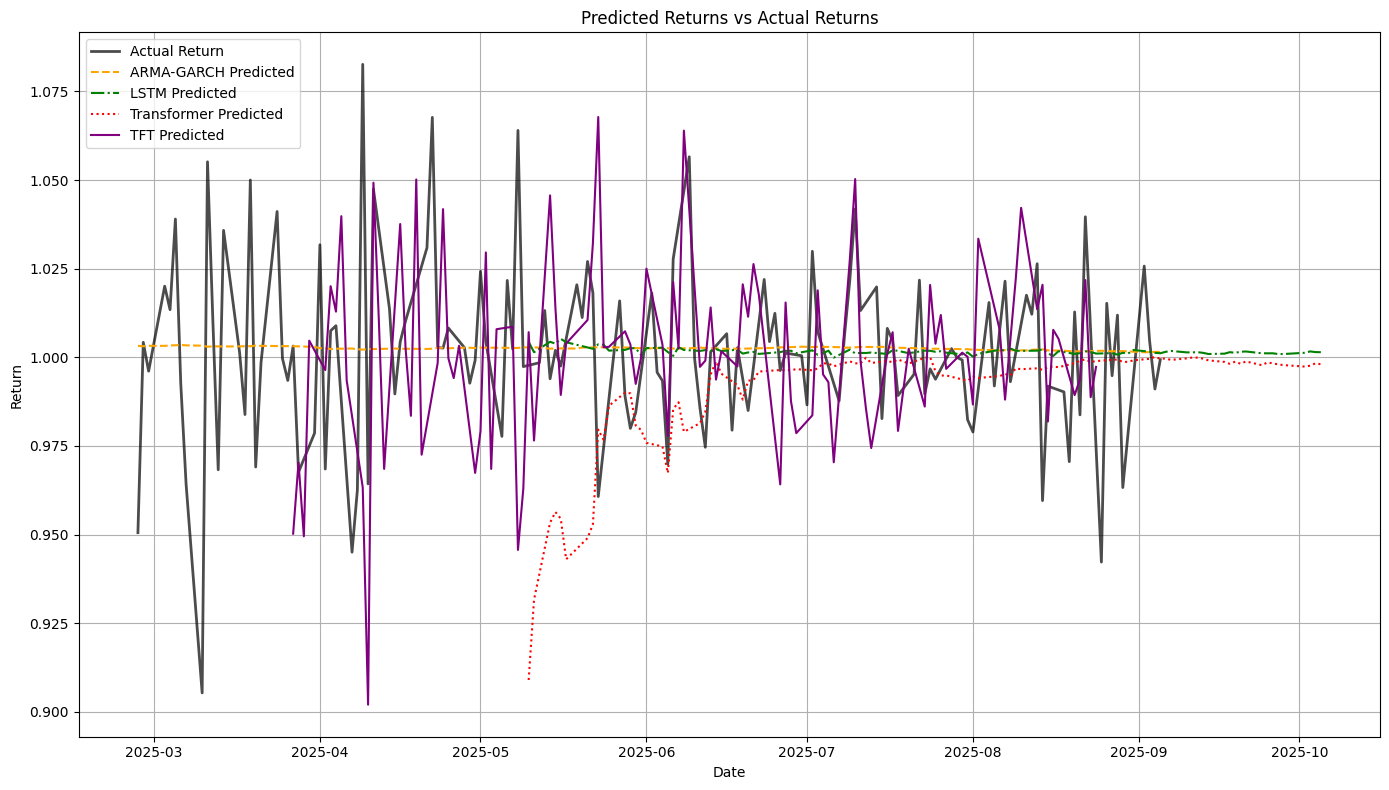

In [ ]:
import matplotlib.pyplot as plt

plt.figure(figsize=(14, 8))

# Plot actual returns (aligned to prediction indices)
plt.plot(actual_returns.index, np.exp(actual_returns), label='Actual Return', color='black', linewidth=2, alpha=0.7)

# ARMA-GARCH
plt.plot(pred_returns_arma.index, np.exp(pred_returns_arma), label='ARMA-GARCH Predicted', linestyle='--', color='orange')

# LSTM
plt.plot(pred_return_lstm.index, pred_return_lstm, label='LSTM Predicted', linestyle='-.', color='green')

# Transformer
plt.plot(pred_return_transformer.index, pred_return_transformer, label='Transformer Predicted', linestyle=':', color='red')

try:
    plt.plot(pred_return_tft.index, pred_return_tft, label='TFT Predicted', linestyle='-', color='purple')
except Exception:
    print("TFT returns not found. Please ensure you have pred_returns_tft.")

plt.title('Predicted Returns vs Actual Returns')
plt.xlabel('Date')
plt.ylabel('Return')
plt.legend(loc='upper left')
plt.grid()
plt.tight_layout()
plt.show()

In [ ]:
print(actual_returns)
print(pred_returns_arma)
print(pred_return_lstm)


Date
2025-02-26   -0.050728
2025-02-27    0.004226
2025-02-28   -0.003918
2025-03-03    0.019863
2025-03-04    0.013348
                ...   
2025-08-29   -0.037423
2025-09-02    0.025408
2025-09-03    0.004689
2025-09-04   -0.008987
2025-09-05   -0.000656
Length: 133, dtype: float64
Date
2025-02-26    0.003230
2025-02-27    0.003120
2025-02-28    0.003239
2025-03-03    0.003222
2025-03-04    0.003329
                ...   
2025-08-29    0.001744
2025-09-02    0.001430
2025-09-03    0.001496
2025-09-04    0.001530
2025-09-05    0.001486
Length: 133, dtype: float64
Date
2025-05-10    1.004359
2025-05-11    1.001428
2025-05-14    1.004378
2025-05-15    1.003848
2025-05-16    1.005210
                ...   
2025-09-28    1.000924
2025-10-02    1.001270
2025-10-03    1.001661
2025-10-04    1.001469
2025-10-05    1.001439
Length: 102, dtype: float64


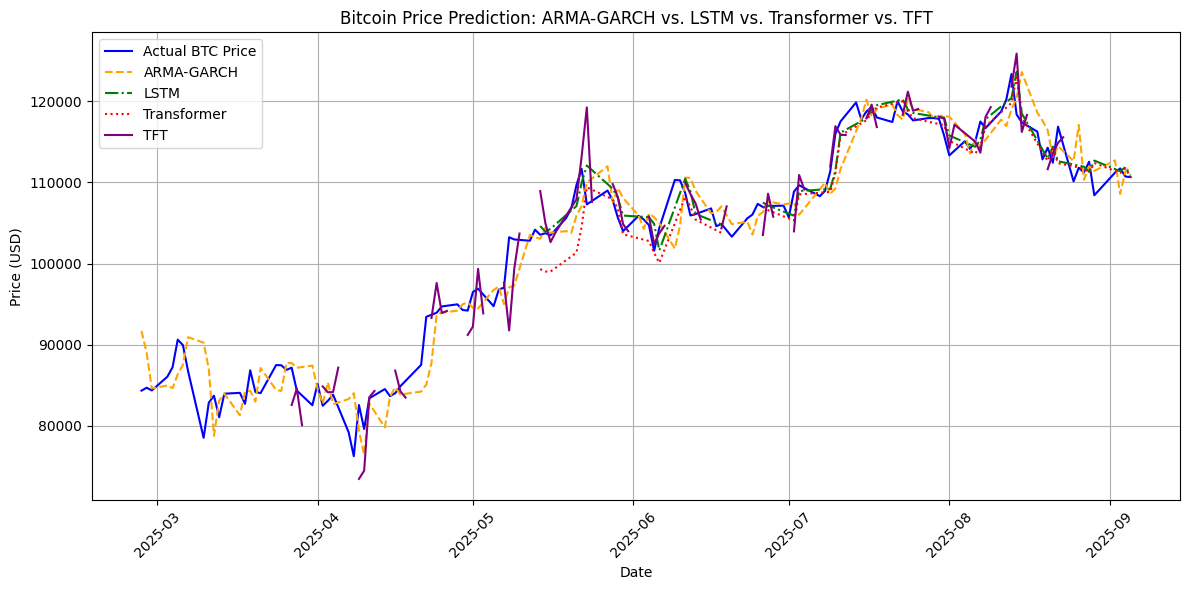

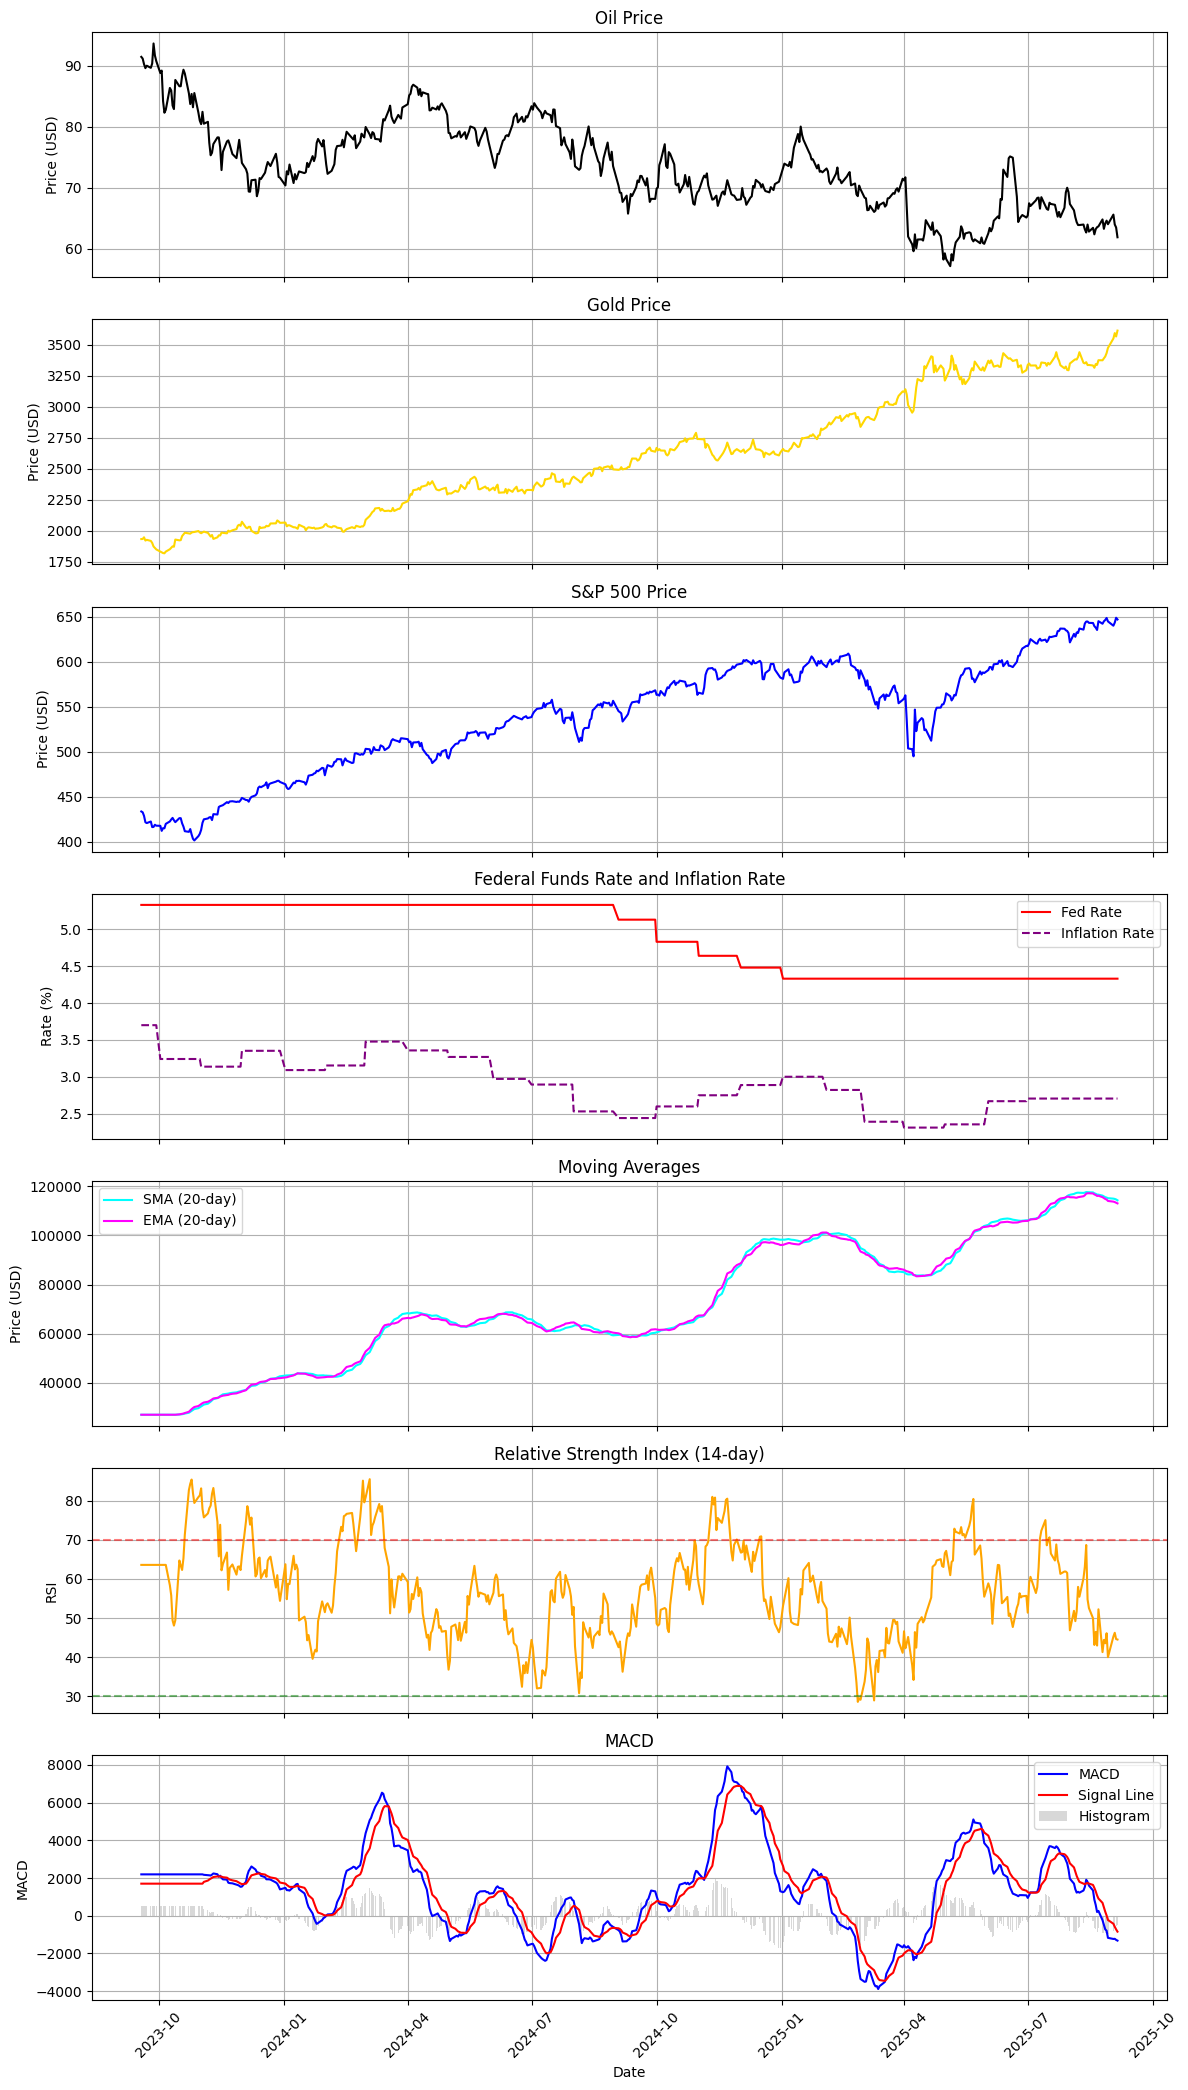

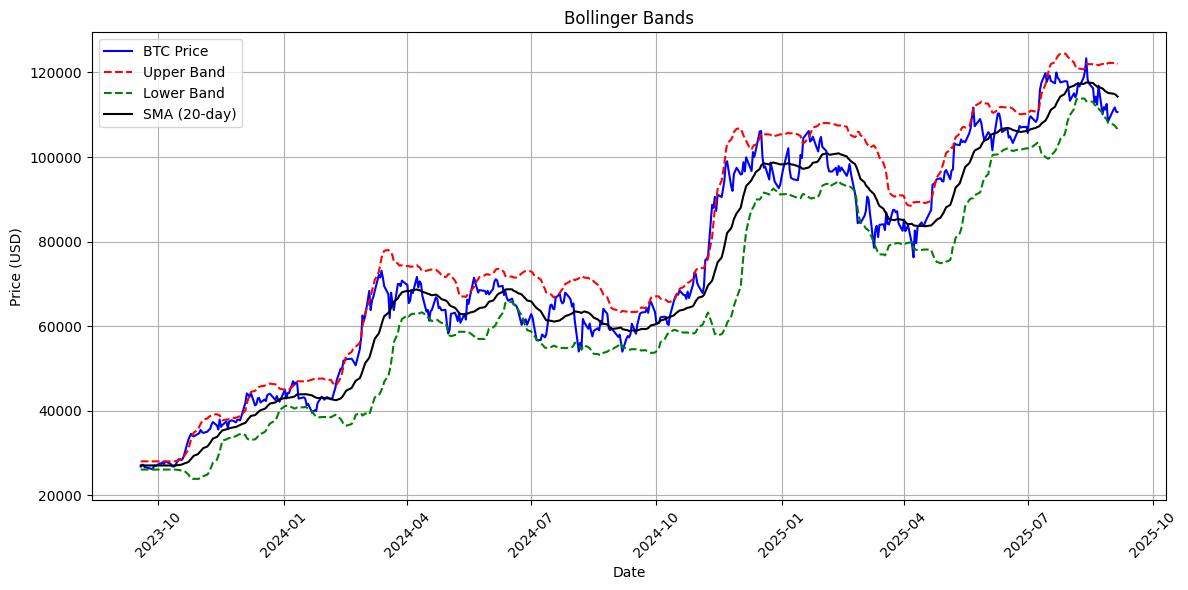

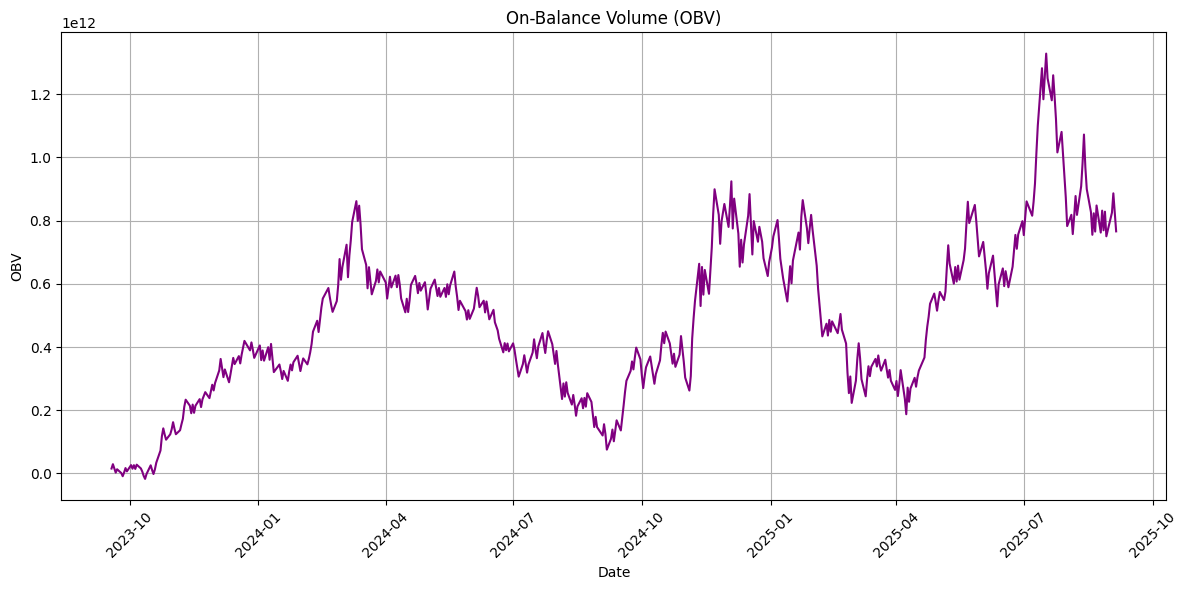


Performance Metrics:
ARMA-GARCH  - RMSE: 3178.23, MAE: 2417.40, MAPE: 2.46%
LSTM        - RMSE: 229.09, MAE: 205.97, MAPE: 0.19%
Transformer - RMSE: 1886.22, MAE: 1116.50, MAPE: 1.04%
TFT         - RMSE: 869.52, MAE: 175.87, MAPE: 0.16%

Last 5 Predicted vs Actual Prices:


,Actual Price,ARMA-GARCH,LSTM,Transformer,TFT,Oil Price (USD),Gold Price (USD),S&P 500 Price (USD),Fed Rate (%),Inflation Rate (%),SMA (20-day),EMA (20-day),RSI (14-day),MACD,MACD Signal,Upper Band,Lower Band,OBV
2025-08-29,108410.84,111416.22,112688.47,112395.22,NaN,64.01,3473.7,645.05,4.33,2.7,115159.47,114020.01,39.99,-1171.45,-223.97,122249.60,108069.33,7.506199e+11
2025-09-02,111200.59,112705.81,NaN,NaN,NaN,65.59,3549.4,640.27,4.33,2.7,114965.90,113751.50,45.27,-1230.95,-425.36,122263.38,107668.43,8.253969e+11
2025-09-03,111723.21,108573.09,111377.83,111152.95,NaN,63.97,3593.2,643.74,4.33,2.7,114844.99,113558.33,46.22,-1221.84,-584.66,122272.09,107417.90,8.865165e+11
2025-09-04,110723.60,111370.89,111864.73,111735.94,NaN,63.48,3565.8,649.12,4.33,2.7,114629.77,113288.35,44.62,-1280.52,-723.83,122269.60,106989.94,8.263854e+11
2025-09-05,110650.98,111889.32,110850.42,110676.65,NaN,61.87,3613.2,647.24,4.33,2.7,114287.48,113037.18,44.50,-1317.70,-842.61,121995.94,106579.02,7.661437e+11


In [ ]:
# Plot results
plt.figure(figsize=(12, 6))
plt.plot(actual_prices.index, actual_prices, label='Actual BTC Price', color='blue')
plt.plot(pred_prices_arma.index, pred_prices_arma, label='ARMA-GARCH', color='orange', linestyle='--')
plt.plot(pred_prices_lstm.index, pred_prices_lstm, label='LSTM', color='green', linestyle='-.')
plt.plot(pred_prices_transformer.index, pred_prices_transformer, label='Transformer', color='red', linestyle=':')
plt.plot(pred_prices_tft.index, pred_prices_tft, label='TFT', color='purple', linestyle='-')
plt.title('Bitcoin Price Prediction: ARMA-GARCH vs. LSTM vs. Transformer vs. TFT')
plt.xlabel('Date')
plt.ylabel('Price (USD)')
plt.legend()
plt.grid()
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

# Plot exogenous variables and technical indicators
fig, axes = plt.subplots(7, 1, figsize=(12, 21), sharex=True)
axes[0].plot(exog.index, exog['oil_price'], color='black')
axes[0].set_title('Oil Price')
axes[0].set_ylabel('Price (USD)')
axes[0].grid()

axes[1].plot(exog.index, exog['gold_price'], color='gold')
axes[1].set_title('Gold Price')
axes[1].set_ylabel('Price (USD)')
axes[1].grid()

axes[2].plot(exog.index, exog['sp500_price'], color='blue')
axes[2].set_title('S&P 500 Price')
axes[2].set_ylabel('Price (USD)')
axes[2].grid()

axes[3].plot(exog.index, exog['fed_rate'], color='red')
axes[3].plot(exog.index, exog['inflation_rate'], color='purple', linestyle='--')
axes[3].set_title('Federal Funds Rate and Inflation Rate')
axes[3].set_ylabel('Rate (%)')
axes[3].legend(['Fed Rate', 'Inflation Rate'])
axes[3].grid()

axes[4].plot(exog.index, exog['sma_20'], color='cyan', label='SMA (20-day)')
axes[4].plot(exog.index, exog['ema_20'], color='magenta', label='EMA (20-day)')
axes[4].set_title('Moving Averages')
axes[4].set_ylabel('Price (USD)')
axes[4].legend()
axes[4].grid()

axes[5].plot(exog.index, exog['rsi_14'], color='orange')
axes[5].axhline(70, color='red', linestyle='--', alpha=0.5)
axes[5].axhline(30, color='green', linestyle='--', alpha=0.5)
axes[5].set_title('Relative Strength Index (14-day)')
axes[5].set_ylabel('RSI')
axes[5].grid()

axes[6].plot(exog.index, exog['macd'], color='blue', label='MACD')
axes[6].plot(exog.index, exog['macd_signal'], color='red', label='Signal Line')
axes[6].bar(exog.index, exog['macd'] - exog['macd_signal'], color='gray', alpha=0.3, label='Histogram')
axes[6].set_title('MACD')
axes[6].set_ylabel('MACD')
axes[6].legend()
axes[6].grid()

plt.xlabel('Date')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

# Plot Bollinger Bands
plt.figure(figsize=(12, 6))
plt.plot(btc_prices.index, btc_prices, label='BTC Price', color='blue')
plt.plot(exog.index, exog['upper_band'], label='Upper Band', color='red', linestyle='--')
plt.plot(exog.index, exog['lower_band'], label='Lower Band', color='green', linestyle='--')
plt.plot(exog.index, exog['sma_20'], label='SMA (20-day)', color='black')
plt.title('Bollinger Bands')
plt.xlabel('Date')
plt.ylabel('Price (USD)')
plt.legend()
plt.grid()
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

# Plot OBV
plt.figure(figsize=(12, 6))
plt.plot(exog.index, exog['obv'], color='purple')
plt.title('On-Balance Volume (OBV)')
plt.xlabel('Date')
plt.ylabel('OBV')
plt.grid()
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

# Drop NaNs for LSTM/Transformer metrics
valid_lstm = (~pd.isna(actual_prices_lstm)) & (~pd.isna(pred_prices_lstm))
actual_prices_lstm_valid = actual_prices_lstm[valid_lstm]
pred_prices_lstm_valid = pred_prices_lstm[valid_lstm]

# Calculate LSTM metrics
rmse_lstm = np.sqrt(mean_squared_error(actual_prices_lstm_valid, pred_prices_lstm_valid))
mae_lstm = mean_absolute_error(actual_prices_lstm_valid, pred_prices_lstm_valid)
mape_lstm = np.mean(np.abs((actual_prices_lstm_valid - pred_prices_lstm_valid) / actual_prices_lstm_valid)) * 100

# Print performance metrics
print("\nPerformance Metrics:")
print(f"ARMA-GARCH  - RMSE: {rmse_arma:.2f}, MAE: {mae_arma:.2f}, MAPE: {mape_arma:.2f}%")
print(f"LSTM        - RMSE: {rmse_lstm:.2f}, MAE: {mae_lstm:.2f}, MAPE: {mape_lstm:.2f}%")
print(f"Transformer - RMSE: {rmse_transformer:.2f}, MAE: {mae_transformer:.2f}, MAPE: {mape_transformer:.2f}%")
print(f"TFT         - RMSE: {rmse_tft:.2f}, MAE: {mae_tft:.2f}, MAPE: {mape_tft:.2f}%")

# Print last 5 predictions
print("\nLast 5 Predicted vs Actual Prices:")
results = pd.DataFrame({
    'Actual Price': actual_prices.round(2),
    'ARMA-GARCH': pred_prices_arma.round(2),
    'LSTM': pred_prices_lstm.round(2),
    'Transformer': pred_prices_transformer.round(2),
    'TFT': pred_prices_tft.round(2),
    'Oil Price (USD)': exog['oil_price'].round(2),
    'Gold Price (USD)': exog['gold_price'].round(2),
    'S&P 500 Price (USD)': exog['sp500_price'].round(2),
    'Fed Rate (%)': exog['fed_rate'].round(2),
    'Inflation Rate (%)': exog['inflation_rate'].round(2),
    'SMA (20-day)': exog['sma_20'].round(2),
    'EMA (20-day)': exog['ema_20'].round(2),
    'RSI (14-day)': exog['rsi_14'].round(2),
    'MACD': exog['macd'].round(2),
    'MACD Signal': exog['macd_signal'].round(2),
    'Upper Band': exog['upper_band'].round(2),
    'Lower Band': exog['lower_band'].round(2),
    'OBV': exog['obv'].round(2)
})
results.tail()

In [ ]:
def classify_direction(predicted, threshold=0.01, horizon=7):
    """
    Classify direction as UP, DOWN, or NO_CHANGE based on predicted price change vs previous predicted price.
    Returns a Series with the same index as input.
    """
    pred_shifted = predicted.shift(horizon)
    pct_change = (predicted - pred_shifted) / pred_shifted
    direction = pct_change.apply(lambda x: "UP" if x >= threshold else ("DOWN" if x <= -threshold else "NO_CHANGE"))
    return direction


In [ ]:
def direction_success_rate(actual, predicted, threshold=0.01, horizon=7):
    """
    Compute the success rate of direction prediction.
    Success = predicted direction matches actual direction.
    """
    actual_dir = classify_direction(actual, threshold, horizon)
    pred_dir = classify_direction(predicted, threshold, horizon)
    # Align indices and drop NaNs
    common_idx = actual_dir.index.intersection(pred_dir.index)
    actual_dir = actual_dir.loc[common_idx].dropna()
    pred_dir = pred_dir.loc[common_idx].dropna()
    valid = actual_dir.index.intersection(pred_dir.index)
    correct = (actual_dir.loc[valid] == pred_dir.loc[valid]).sum()
    total = len(valid)
    return correct / total if total > 0 else np.nan

threshold=0.05

# Example usage:
print("ARMA-GARCH direction success rate:", direction_success_rate(actual_prices, pred_prices_arma, threshold, horizon))
print("LSTM direction success rate:", direction_success_rate(actual_prices_lstm, pred_prices_lstm, threshold, horizon))
print("Transformer direction success rate:", direction_success_rate(actual_prices_transformer, pred_prices_transformer, threshold, horizon))
print("TFT direction success rate:", direction_success_rate(actual_prices_tft, pred_prices_tft, threshold, horizon))

ARMA-GARCH direction success rate: 0.8872180451127819
LSTM direction success rate: 1.0
Transformer direction success rate: 0.9791666666666666
TFT direction success rate: 1.0


In [ ]:
def find_best_threshold(actual, predicted, horizon=7, thresholds=np.arange(0.005, 0.10, 0.005)):
    """
    Find the threshold that yields the highest direction prediction success rate.
    Returns the best threshold and a DataFrame of all results.
    """
    results = []
    for t in thresholds:
        rate = direction_success_rate(actual, predicted, threshold=t, horizon=horizon)
        results.append({'threshold': t, 'success_rate': rate})
    df = pd.DataFrame(results)
    best_row = df.loc[df['success_rate'].idxmax()]
    print(f"Best threshold: {best_row['threshold']:.3f} (Success rate: {best_row['success_rate']:.3f})")
    return best_row['threshold'], df

best_arma_threshold, arma_threshold_results = find_best_threshold(actual_prices, pred_prices_arma, horizon=horizon)
print('Best ARMA threshold')
print(best_arma_threshold)
print(arma_threshold_results)

best_lstm_threshold, lstm_threshold_results = find_best_threshold(actual_prices_lstm, pred_prices_lstm, horizon=horizon)
print('Best LSTM threshold')
print(best_lstm_threshold)
print(lstm_threshold_results)

best_transformer_threshold, transformer_threshold_results = find_best_threshold(actual_prices_transformer, pred_prices_transformer, horizon=horizon)
print('Best Transformer threshold')
print(best_transformer_threshold)
print(transformer_threshold_results)

best_tft_threshold, tft_threshold_results = find_best_threshold(actual_prices_tft, pred_prices_tft, horizon=horizon)
print('Best TFT threshold')
print(best_tft_threshold)
print(tft_threshold_results)

Best threshold: 0.005 (Success rate: 0.940)
Best ARMA threshold
0.005
    threshold  success_rate
0       0.005      0.939850
1       0.010      0.924812
2       0.015      0.909774
3       0.020      0.894737
4       0.025      0.864662
5       0.030      0.857143
6       0.035      0.879699
7       0.040      0.872180
8       0.045      0.887218
9       0.050      0.887218
10      0.055      0.872180
11      0.060      0.887218
12      0.065      0.879699
13      0.070      0.887218
14      0.075      0.879699
15      0.080      0.857143
16      0.085      0.849624
17      0.090      0.849624
18      0.095      0.849624
Best threshold: 0.005 (Success rate: 1.000)
Best LSTM threshold
0.005
    threshold  success_rate
0       0.005      1.000000
1       0.010      1.000000
2       0.015      1.000000
3       0.020      1.000000
4       0.025      1.000000
5       0.030      1.000000
6       0.035      1.000000
7       0.040      1.000000
8       0.045      1.000000
9       0.050      1

In [ ]:
def simulate_strategy(direction, price, initial_cash=10000):
    cash = initial_cash
    btc = 0
    last_action = None
    history = []

    for date in direction.index:
        signal = direction.loc[date]
        p = price.loc[date]
        if np.isnan(p):
            history.append((date, cash, btc, signal, last_action))
            continue

        if signal == "UP" and btc == 0:
            btc = cash / p
            cash = 0
            last_action = "BUY"
        elif signal == "DOWN" and btc > 0:
            cash = btc * p
            btc = 0
            last_action = "SELL"
        else:
            last_action = "HOLD"
        history.append((date, cash, btc, signal, last_action))

    # Liquidate any BTC at the last available price
    if btc > 0:
        cash += btc * price.dropna().iloc[-1]
        btc = 0

    return cash, pd.DataFrame(history, columns=["date", "cash", "btc", "signal", "action"])

In [ ]:
def find_best_threshold_pnl(predicted, price, horizon=7, thresholds=np.arange(0.005, 0.10, 0.005), initial_cash=10000):
    """
    Find the threshold that yields the highest simulated trading profit (PnL).
    Returns the best threshold and a DataFrame of all results.
    """
    results = []
    for t in thresholds:
        direction = classify_direction(predicted, threshold=t, horizon=horizon)
        final_cash, _ = simulate_strategy(direction, price, initial_cash=initial_cash)
        profit = final_cash - initial_cash
        results.append({'threshold': t, 'final_cash': final_cash, 'profit': profit})
    df = pd.DataFrame(results)
    best_row = df.loc[df['profit'].idxmax()]
    print(f"Best threshold by PnL: {best_row['threshold']:.3f} (Profit: ${best_row['profit']:.2f})")
    return best_row['threshold'], df

In [ ]:
best_arma_threshold, arma_threshold_results = find_best_threshold_pnl(actual_prices, pred_prices_arma, horizon=horizon)
print('Best ARMA threshold')
print(best_arma_threshold)
print(arma_threshold_results)

best_lstm_threshold, lstm_threshold_results = find_best_threshold_pnl(actual_prices_lstm, pred_prices_lstm, horizon=horizon)
print('Best LSTM threshold')
print(best_lstm_threshold)
print(lstm_threshold_results)

best_transformer_threshold, transformer_threshold_results = find_best_threshold_pnl(actual_prices_transformer, pred_prices_transformer, horizon=horizon)
print('Best Transformer threshold')
print(best_transformer_threshold)
print(transformer_threshold_results)

best_tft_threshold, tft_threshold_results = find_best_threshold_pnl(actual_prices_tft, pred_prices_tft, horizon=horizon)
print('Best TFT threshold')
print(best_tft_threshold)
print(tft_threshold_results)

Best threshold by PnL: 0.005 (Profit: $3489.19)
Best ARMA threshold
0.005
    threshold    final_cash       profit
0       0.005  13489.190863  3489.190863
1       0.010  13351.459990  3351.459990
2       0.015  13446.011257  3446.011257
3       0.020  13446.011257  3446.011257
4       0.025  13281.152222  3281.152222
5       0.030  13281.152222  3281.152222
6       0.035  13234.465186  3234.465186
7       0.040  13234.465186  3234.465186
8       0.045  13234.465186  3234.465186
9       0.050  13234.465186  3234.465186
10      0.055  13234.465186  3234.465186
11      0.060  13234.465186  3234.465186
12      0.065  13234.465186  3234.465186
13      0.070  13234.465186  3234.465186
14      0.075  13234.465186  3234.465186
15      0.080  13234.465186  3234.465186
16      0.085  13147.778074  3147.778074
17      0.090  13147.778074  3147.778074
18      0.095  13147.778074  3147.778074
Best threshold by PnL: 0.005 (Profit: $-607.44)
Best LSTM threshold
0.005
    threshold   final_cash      

In [ ]:

# Example usage for each model:
direction_arma = classify_direction(pred_prices_arma, best_arma_threshold, horizon)
direction_lstm = classify_direction(pred_prices_lstm, best_lstm_threshold, horizon)
direction_transformer = classify_direction(pred_prices_transformer, best_transformer_threshold, horizon)
direction_tft = classify_direction(pred_prices_tft, best_tft_threshold, horizon)

print("ARMA-GARCH direction:\n", direction_arma.tail())
print("LSTM direction:\n", direction_lstm.tail())
print("Transformer direction:\n", direction_transformer.tail())
print("TFT direction:\n", direction_tft.tail())

ARMA-GARCH direction:
 Date
2025-08-29    DOWN
2025-09-02    DOWN
2025-09-03    DOWN
2025-09-04    DOWN
2025-09-05    DOWN
dtype: object
LSTM direction:
 Date
2025-08-28           UP
2025-08-29           UP
2025-09-03           UP
2025-09-04    NO_CHANGE
2025-09-05           UP
dtype: object
Transformer direction:
 Date
2025-08-28           UP
2025-08-29           UP
2025-09-03           UP
2025-09-04    NO_CHANGE
2025-09-05           UP
dtype: object
TFT direction:
 2025-08-20    NO_CHANGE
2025-08-21    NO_CHANGE
2025-08-22    NO_CHANGE
2025-08-23    NO_CHANGE
2025-08-24    NO_CHANGE
dtype: object


In [ ]:
# Shift direction markers by the prediction horizon
direction_arma_shifted = direction_arma.copy()
direction_arma_shifted.index = direction_arma_shifted.index - pd.DateOffset(horizon)
pred_prices_arma_shifted = pred_prices_arma.copy()
pred_prices_arma_shifted.index = pred_prices_arma_shifted.index - pd.DateOffset(horizon)

direction_lstm_shifted = direction_lstm.copy()
direction_lstm_shifted.index = direction_lstm_shifted.index - pd.DateOffset(horizon)
pred_prices_lstm_shifted = pred_prices_lstm.copy()
pred_prices_lstm_shifted.index = pred_prices_lstm_shifted.index - pd.DateOffset(horizon)

direction_transformer_shifted = direction_transformer.copy()
direction_transformer_shifted.index = direction_transformer_shifted.index - pd.DateOffset(horizon)
pred_prices_transformer_shifted = pred_prices_transformer.copy()
pred_prices_transformer_shifted.index = pred_prices_transformer_shifted.index - pd.DateOffset(horizon)

direction_tft_shifted = direction_tft.copy()
direction_tft_shifted.index = direction_tft_shifted.index - pd.DateOffset(horizon)
pred_prices_tft_shifted = pred_prices_tft.copy()
pred_prices_tft_shifted.index = pred_prices_tft_shifted.index - pd.DateOffset(horizon)


In [ ]:
def plot_directions(direction, price, label_prefix, marker, color):
    for dir_label, m, c in zip(["UP", "DOWN"], ["^", "v"], ["green", "red"]):
        idx = direction[direction == dir_label].index
        # Reindex price to match direction index, fill missing with NaN or ffill
        price_on_idx = price.reindex(idx)
        # Optionally: price_on_idx = price.reindex(idx).ffill()  # or .bfill()
        valid_idx = price_on_idx.dropna().index
        if len(valid_idx) > 0:
            plt.scatter(valid_idx, price_on_idx.loc[valid_idx], marker=m, color=c, s=60, alpha=0.7, label=f"{label_prefix} {dir_label}" if label_prefix else dir_label)

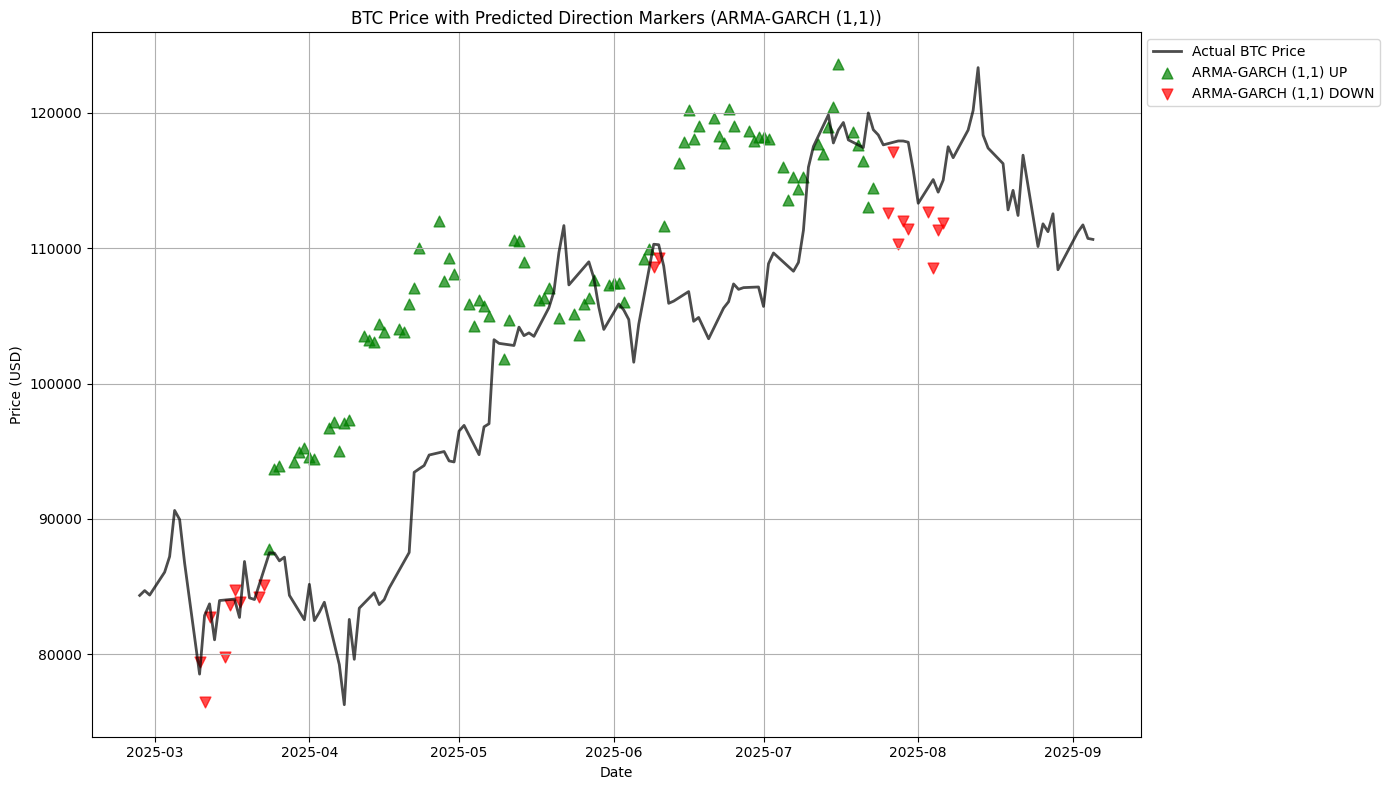

In [ ]:
plt.figure(figsize=(14, 8))
plt.plot(actual_prices.index, actual_prices, label='Actual BTC Price', color='black', linewidth=2, alpha=0.7)


# Plot for each model
plot_directions(direction_arma_shifted, pred_prices_arma_shifted, "ARMA-GARCH (1,1)", "^", "green")

plt.title("BTC Price with Predicted Direction Markers (ARMA-GARCH (1,1))")
plt.xlabel("Date")
plt.ylabel("Price (USD)")
plt.legend(loc='upper left', bbox_to_anchor=(1, 1))
plt.grid()
plt.tight_layout()
plt.show()

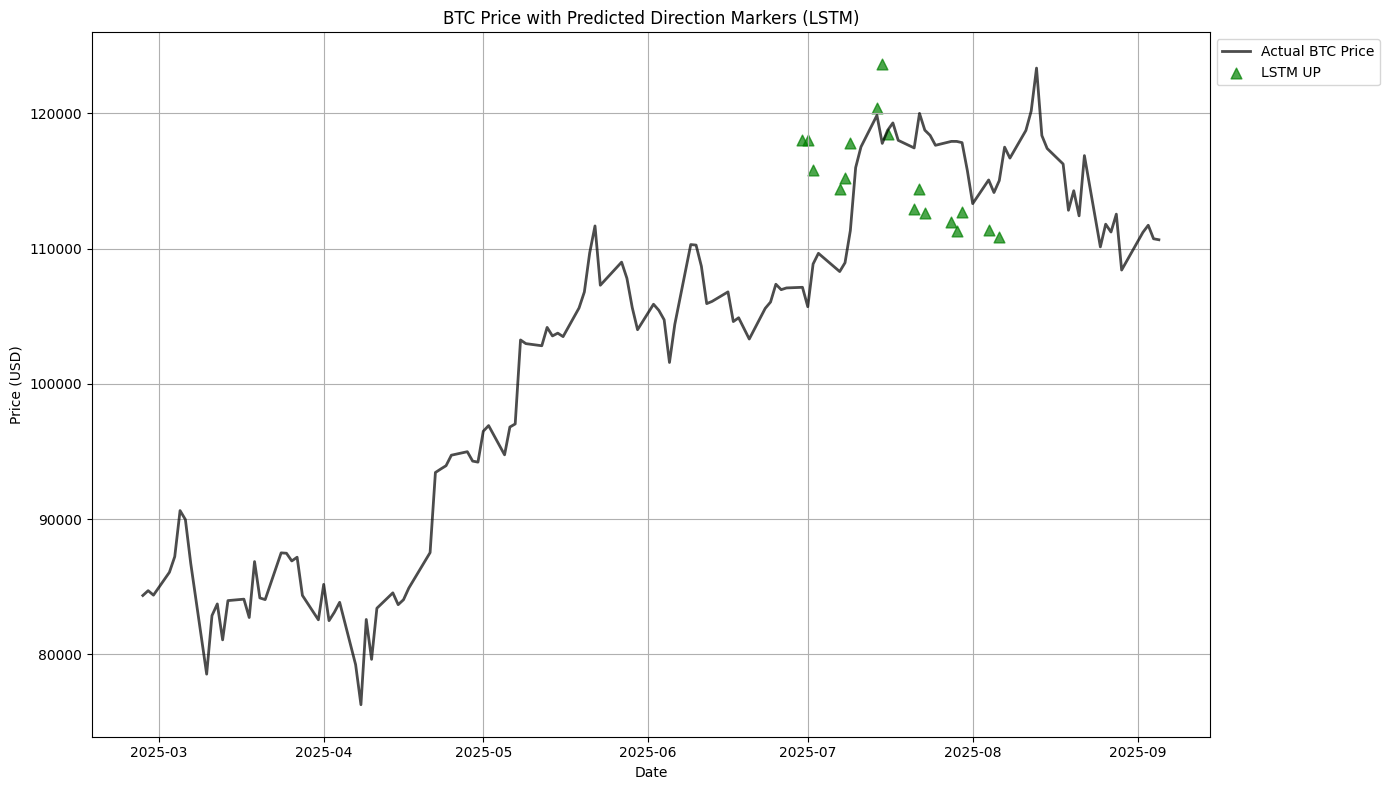

In [ ]:
plt.figure(figsize=(14, 8))
plt.plot(actual_prices.index, actual_prices, label='Actual BTC Price', color='black', linewidth=2, alpha=0.7)

# Plot for each model
plot_directions(direction_lstm_shifted, pred_prices_lstm_shifted, "LSTM", "s", "blue")

plt.title("BTC Price with Predicted Direction Markers (LSTM)")
plt.xlabel("Date")
plt.ylabel("Price (USD)")
plt.legend(loc='upper left', bbox_to_anchor=(1, 1))
plt.grid()
plt.tight_layout()
plt.show()

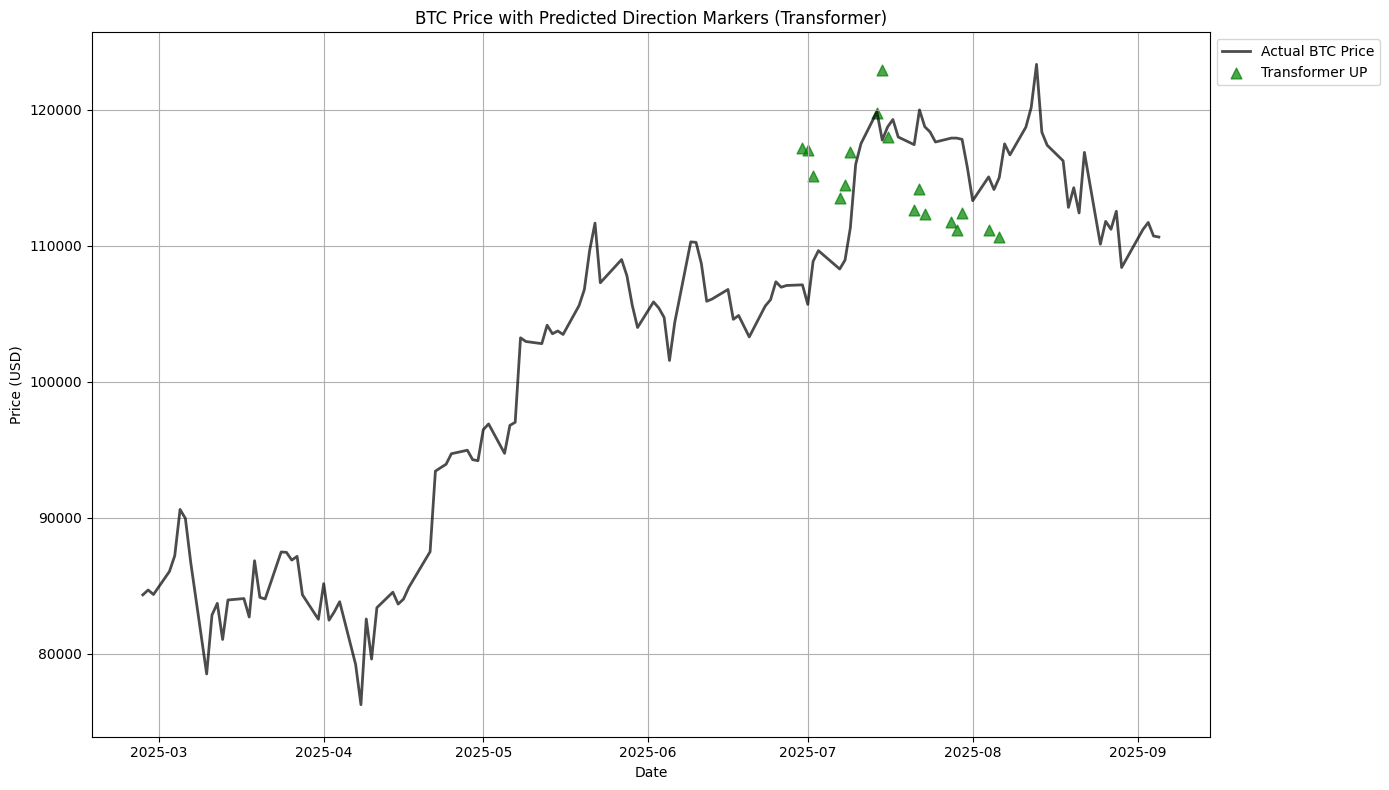

In [ ]:
plt.figure(figsize=(14, 8))
plt.plot(actual_prices.index, actual_prices, label='Actual BTC Price', color='black', linewidth=2, alpha=0.7)


# Plot for each model
plot_directions(direction_transformer_shifted, pred_prices_transformer_shifted, "Transformer", "D", "orange")

plt.title("BTC Price with Predicted Direction Markers (Transformer)")
plt.xlabel("Date")
plt.ylabel("Price (USD)")
plt.legend(loc='upper left', bbox_to_anchor=(1, 1))
plt.grid()
plt.tight_layout()
plt.show()

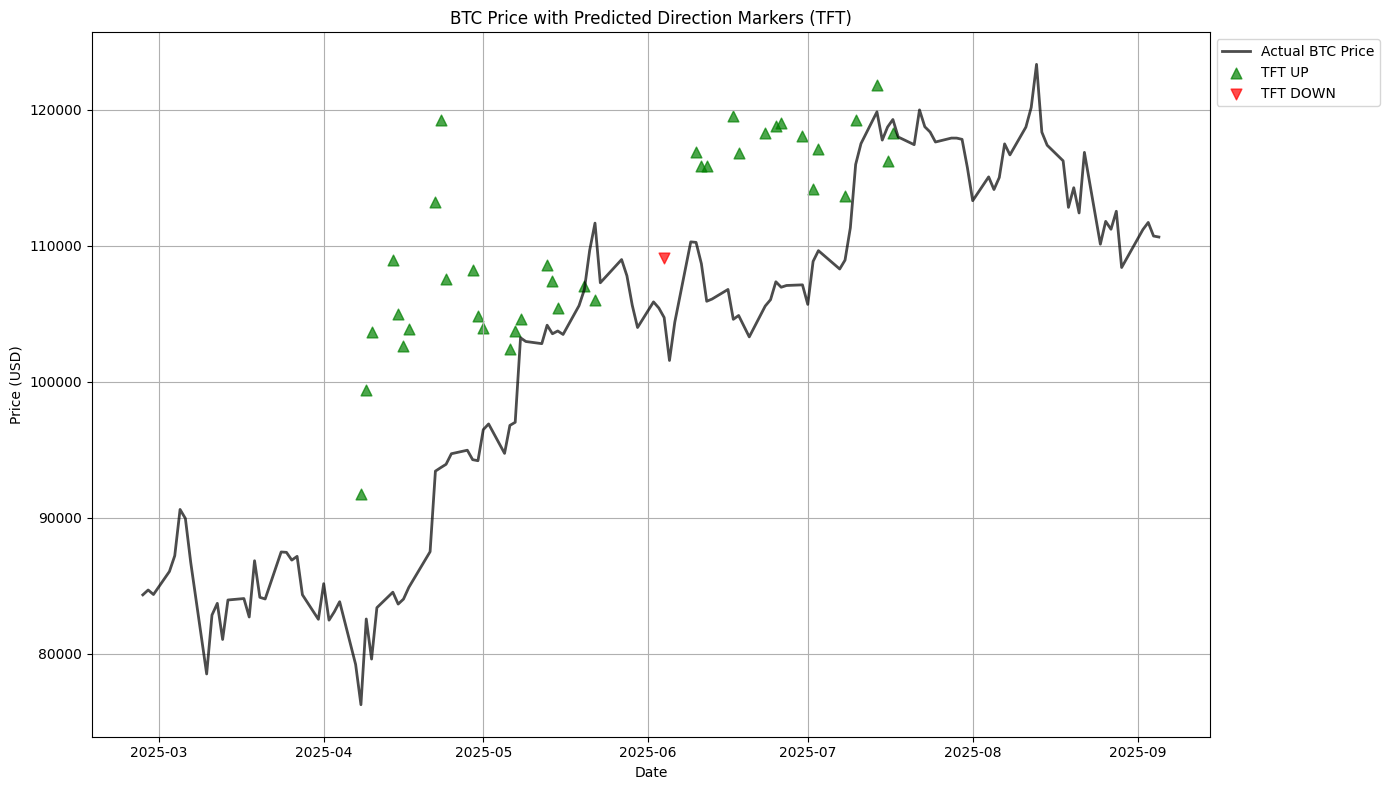

In [ ]:
plt.figure(figsize=(14, 8))
plt.plot(actual_prices.index, actual_prices, label='Actual BTC Price', color='black', linewidth=2, alpha=0.7)

plot_directions(direction_tft_shifted, pred_prices_tft_shifted, "TFT", "P", "purple")

plt.title("BTC Price with Predicted Direction Markers (TFT)")
plt.xlabel("Date")
plt.ylabel("Price (USD)")
plt.legend(loc='upper left', bbox_to_anchor=(1, 1))
plt.grid()
plt.tight_layout()
plt.show()

In [ ]:


# Run for all models
results = {}
for name, direction, price in [
    ("ARMA-GARCH", direction_arma, pred_prices_arma),
    ("LSTM", direction_lstm, pred_prices_lstm),
    ("Transformer", direction_transformer, pred_prices_transformer),
    ("TFT", direction_tft, pred_prices_tft)
]:
    final_cash, trade_history = simulate_strategy(direction, price)
    profit = final_cash - 10000
    percent = (profit / 10000) * 100
    results[name] = (final_cash, profit, percent)
    print(f"{name} strategy final value: ${final_cash:.2f} (Profit: ${profit:.2f}, {percent:.2f}%)")
# ...existing code...

# Optional: Show last trades for one model
# trade_history.tail()

ARMA-GARCH strategy final value: $12484.00 (Profit: $2484.00, 24.84%)
LSTM strategy final value: $9392.56 (Profit: $-607.44, -6.07%)
Transformer strategy final value: $9444.65 (Profit: $-555.35, -5.55%)
TFT strategy final value: $11752.82 (Profit: $1752.82, 17.53%)


In [ ]:
import pandas as pd
from scipy.stats import skew, kurtosis

def describe_errors(y_true, y_pred, name):
    # Align and drop NaNs
    common_idx = y_true.index.intersection(y_pred.index)
    y_true = y_true.loc[common_idx].dropna()
    y_pred = y_pred.loc[common_idx].dropna()
    errors = y_true - y_pred
    desc = errors.describe(percentiles=[.01, .05, .25, .5, .75, .95, .99])
    desc['skew'] = skew(errors)
    desc['kurtosis'] = kurtosis(errors)
    print(f"\n{name} Prediction Error Descriptive Statistics:")
    print(desc)
    return desc

# Descriptive statistics for all models
desc_arma = describe_errors(actual_prices, pred_prices_arma, "ARMA-GARCH")
desc_lstm = describe_errors(actual_prices_lstm, pred_prices_lstm, "LSTM")
desc_transformer = describe_errors(actual_prices_transformer, pred_prices_transformer, "Transformer")
desc_tft = describe_errors(actual_prices_tft, pred_prices_tft, "TFT")

# Optionally, describe the predictions themselves
def describe_predictions(y_pred, name):
    desc = y_pred.describe(percentiles=[.01, .05, .25, .5, .75, .95, .99])
    desc['skew'] = skew(y_pred.dropna())
    desc['kurtosis'] = kurtosis(y_pred.dropna())
    print(f"\n{name} Predictions Descriptive Statistics:")
    print(desc)
    return desc

describe_predictions(pred_prices_arma, "ARMA-GARCH")
describe_predictions(pred_prices_lstm, "LSTM")
describe_predictions(pred_prices_transformer, "Transformer")
describe_predictions(pred_prices_tft, "TFT")


ARMA-GARCH Prediction Error Descriptive Statistics:
count         133.000000
mean           52.149606
std          3189.816090
min        -11725.192771
1%          -7635.378544
5%          -4767.732704
25%         -1909.620575
50%           -87.902460
75%          2032.237064
95%          5623.160010
99%          7825.000828
max          8457.956494
skew           -0.166176
kurtosis        1.027165
dtype: float64

LSTM Prediction Error Descriptive Statistics:
count        47.000000
mean       -205.965234
std         101.375284
min        -540.469103
1%         -501.662707
5%         -406.786416
25%        -242.518956
50%        -198.537953
75%        -137.484058
95%         -77.605395
99%         -29.785621
max         -19.033758
skew         -1.063842
kurtosis      1.795539
dtype: float64

Transformer Prediction Error Descriptive Statistics:
count         47.000000
mean        1115.647894
std         1537.354438
min          -12.731119
1%           -10.234974
5%            23.332358


,0
count,82.000000
mean,104536.496269
std,12697.606135
min,73474.362817
1%,74291.582979
5%,83497.499750
25%,95027.502866
50%,106534.528077
75%,115426.288230
95%,119263.315337


## Notes
- **API Key**: Replace `YOUR_FRED_API_KEY` with your key from [fred.stlouisfed.org](https://fred.stlouisfed.org).
- **Technical Indicators**:
  - **SMA/EMA (20-day)**: Smooth price trends, identify support/resistance.
  - **RSI (14-day)**: Detects overbought/oversold conditions.
  - **MACD**: Captures trend and momentum via EMA differences.
  - **Bollinger Bands**: Measures volatility with upper/lower bands.
  - **OBV**: Tracks volume to confirm price trends.
- **Data** (as of August 8, 2025):
  - Gold: ~$3,362.51/oz (August 1, 2025).
  - Fed Rate: 4.25%–4.50% (July 2025).
  - Inflation: 2.7% (June 2025).
  - Oil, S&P 500: Fetched via `yfinance`.
- **TFT Configuration**:
  - Uses `pytorch_forecasting` with a simplified setup (10 epochs, small hidden size) to reduce computation time.
  - Handles all 13 exogenous variables effectively via variable selection networks.
- **Limitations**:
  - TFT training is computationally intensive; consider GPU acceleration.
  - Forward-filled monthly data (Fed rate, inflation) may reduce precision.
  - Excluding whale data may slightly reduce performance if it was a significant predictor.
- **Performance**:
  - **ARMA-GARCH**: Strong for volatility modeling.
  - **LSTM/Transformer**: Capture non-linear patterns but may overfit with 13 features.
  - **TFT**: Likely to perform best due to advanced variable selection and attention mechanisms.
- **Enhancements**:
  - Add confidence intervals for TFT predictions using `tft.predict(..., return_y=True, quantiles=[0.1, 0.9])`.
  - Use PCA to reduce dimensionality if overfitting occurs.
  - Tune TFT hyperparameters (e.g., `hidden_size`, `attention_head_size`).
- **Alternative to ta-lib**: Use `pandas_ta` if `ta-lib` installation fails:
  ```bash
  pip install pandas-ta
  ```
  Replace `calculate_technical_indicators` with:
  ```python
  import pandas_ta as ta
  def calculate_technical_indicators(prices, volume):
      df = pd.DataFrame({'close': prices, 'volume': volume}, index=prices.index)
      df['sma_20'] = ta.sma(df['close'], length=20)
      df['ema_20'] = ta.ema(df['close'], length=20)
      df['rsi_14'] = ta.rsi(df['close'], length=14)
      df['macd'] = ta.macd(df['close'], fast=12, slow=26, signal=9)['MACD_12_26_9']
      df['macd_signal'] = ta.macd(df['close'], fast=12, slow=26, signal=9)['MACDs_12_26_9']
      df['upper_band'] = ta.bbands(df['close'], length=20, std=2)['BBU_20_2.0']
      df['lower_band'] = ta.bbands(df['close'], length=20, std=2)['BBL_20_2.0']
      df['obv'] = ta.obv(df['close'], df['volume'])
      return df[['sma_20', 'ema_20', 'rsi_14', 'macd', 'macd_signal', 'upper_band', 'lower_band', 'obv']].dropna()
  ```
